In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.font_manager as fm
import koreanize_matplotlib

# 폰트 경로 확인 및 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 설치된 폰트 경로
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# 한글 깨짐 방지 - 마이너스 기호 처리
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
group_df = pd.read_parquet('gs://final_project_enuyu/data/final_project/votes/accounts_group.parquet')

school_df = pd.read_parquet('gs://final_project_enuyu/data/final_project/votes/accounts_school.parquet')

user_df = pd.read_parquet('gs://final_project_enuyu/data/final_project/votes/accounts_user.parquet')

questionset_df = pd.read_parquet('gs://final_project_enuyu/data/final_project/votes/polls_questionset.parquet')



In [ ]:
# 2. school_info 구성: group_id → school_id 연결 + 학교 정보 merge
group_df = group_df.rename(columns={'id': 'group_id'})  # group_id 명확히
school_info = pd.merge(group_df, school_df[['id', 'school_type', 'student_count']],
                       left_on='school_id', right_on='id', how='left').drop(columns='id')

# 3. user_df 전처리 (필요한 컬럼만 + 날짜/운영자 필터링)
user_df = user_df[['id', 'created_at', 'gender', 'group_id', 'is_staff', 'is_superuser']]
user_df['created_at'] = pd.to_datetime(user_df['created_at'])

# 8월 이전 가입자 중 운영자 제외
user_df = user_df.loc[
    (user_df['created_at'] < '2023-08-01') &
    (user_df['is_staff'] != 1) &
    (user_df['is_superuser'] != 1)
]

# 4. group_id 기준으로 스쿨 인포와 머지
user_school_df = pd.merge(user_df, school_info, on='group_id', how='left')

# 5. 질문 데이터 전처리
question_df = (
    questionset_df[['id', 'status', 'created_at', 'user_id']]
    .assign(created_at=lambda df: pd.to_datetime(df['created_at']))
    .query("created_at < '2023-08-01' and status != 'B'")
    .assign(day=lambda df: df['created_at'].dt.floor('D'))  # 하루 단위로
    .drop_duplicates(subset=['user_id', 'day'])  # 중복 제거
)

# 6. 질문 기록과 유저-학교 정보 병합
question_record = pd.merge(
    questionset_df.drop(columns='id'),
    user_school_df.rename(columns={'id': 'user_id'})[['user_id', 'gender', 'school_id']],
    on='user_id',
    how='left'
)

### 질문에 참여한 유저가 속한 학교의 개수

In [4]:
question_record['school_id'].nunique()

10

In [5]:
# 학교 ID 목록
question_record['school_id'].dropna().unique()

array([ 271., 4516.,  369.,  352., 1478., 5520., 5491., 5372., 1719.,
       4426.])

### 질문에 참여한 유저 수

In [6]:
question_record['user_id'].nunique()

4972

In [7]:
user_df['id'].nunique()

673183

In [8]:
total_user_count = user_df['id'].nunique()
print(f"전체 가입 유저 수: {total_user_count}")

전체 가입 유저 수: 673183


### 질문 기능 노출된 학교에 속한 유저 수(분모)

In [9]:
# 질문에 참여한 school_id 목록
participating_schools = question_record['school_id'].dropna().unique()

# 해당 학교에 속한 유저 수 (중복 없이)
participating_user_count = user_school_df[
    user_school_df['school_id'].isin(participating_schools)
]['id'].nunique()

print(f"질문 기능 노출된 학교 소속 유저 수 (분모): {participating_user_count}")

질문 기능 노출된 학교 소속 유저 수 (분모): 5074


In [10]:
actual_participation_rate = 4972 / participating_user_count
print(f"질문 기능 노출 유저 기준 참여율: {actual_participation_rate:.2%}")

질문 기능 노출 유저 기준 참여율: 97.99%


In [11]:
# 투표기록 불러오가
userquestionrecord_df = pd.read_parquet('gs://final_project_enuyu/data/final_project/votes/accounts_userquestionrecord.parquet')


In [12]:
# 1. userquestionrecord_df 전처리
userquestionrecord_df['created_at'] = pd.to_datetime(userquestionrecord_df['created_at'])

# 2. user_id 기준으로 학교/성별 정보 merge
record_with_school = pd.merge(
    userquestionrecord_df,
    user_school_df.rename(columns={'id': 'user_id'})[['user_id', 'gender', 'school_id']],
    on='user_id',
    how='left'
)

# 3. question_id 기준으로 질문 정보 merge (질문 생성일, 질문 유저 등)
questionset_df = questionset_df.rename(columns={'id': 'question_id'})  # 병합을 위해 id → question_id
record_merged = pd.merge(
    record_with_school,
    questionset_df[['question_id', 'user_id', 'created_at', 'status']],
    on='question_id',
    how='left',
    suffixes=('', '_question')
)

# 4. 날짜 필터링 (2023-05-26 이전 참여만)
record_merged = record_merged[record_merged['created_at'] < '2023-05-26']


### 응답률

In [13]:
# 1. 열람된 레코드만 필터링
read_df = record_merged[record_merged['has_read'] == 1]

# 2. 응답한 경우 (공개 or 비공개 → answer_status != 'N')
responded_df = read_df[read_df['answer_status'] != 'N']

# 3. 수치 요약
total_records = len(record_merged)
read_count = len(read_df)
responded_count = len(responded_df)
unread_count = total_records - read_count
no_response_count = read_count - responded_count

# 4. 비율 계산
response_rate = responded_count / read_count if read_count > 0 else 0
no_response_rate = no_response_count / read_count if read_count > 0 else 0

# 5. 출력
print("[응답률 요약]")
print(f"전체 질문 수: {total_records:,} (100%)")
print(f"열람된 수: {read_count:,} ({read_count / total_records:.2%})")
print(f"열람되지 않은 수: {unread_count:,} ({unread_count / total_records:.2%})")
print(f"→ 열람 후 응답한 수: {responded_count:,} ({response_rate:.2%})")
print(f"→ 열람 후 미응답 수: {no_response_count:,} ({no_response_rate:.2%})")


[응답률 요약]
전체 질문 수: 1,015,471 (100%)
열람된 수: 575,781 (56.70%)
열람되지 않은 수: 439,690 (43.30%)
→ 열람 후 응답한 수: 104,335 (18.12%)
→ 열람 후 미응답 수: 471,446 (81.88%)


In [14]:
# 1. 날짜 필터링 (2023)
df_4to5 = record_merged[
    (record_merged['created_at'] >= '2023-04-29') &
    (record_merged['created_at'] < '2023-05-26')
]

# 2. 열람한 데이터만 필터링
read_df = df_4to5[df_4to5['has_read'] == 1]

# 3. 그중 응답한 데이터 (answer_status != 'N')
responded_df = read_df[read_df['answer_status'] != 'N']

# 4. 응답률 계산
response_rate = len(responded_df) / len(read_df) if len(read_df) > 0 else 0

# 5. 결과 출력
print(f"[2023년 4월 29일 ~ 5월 25일] 열람자 기준 응답률 (answer_status != 'N'): {response_rate:.2%}")


[2023년 4월 29일 ~ 5월 25일] 열람자 기준 응답률 (answer_status != 'N'): 18.13%


In [15]:
responded_df

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times,gender,school_id,user_id_question,created_at_question,status_question
10109,945319,I,2023-04-29 13:22:05,849995,132,851717,1213085,1,P,2023-05-06 10:31:30,0,3,M,271.0,NaN,NaT,NaN
11512,989867,C,2023-04-29 15:20:38,849498,315,850180,1259999,1,A,2023-05-12 15:33:47,0,0,M,271.0,NaN,NaT,NaN
13156,1027358,C,2023-04-29 17:28:16,855041,325,852472,1319841,1,A,2023-05-06 02:38:30,0,0,F,271.0,NaN,NaT,NaN
14190,1042107,C,2023-04-29 20:23:14,855041,221,852472,1366954,1,A,2023-05-06 02:38:42,0,0,F,271.0,NaN,NaT,NaN
14756,1056511,C,2023-04-30 00:31:08,850868,148,850986,1376548,1,A,2023-05-22 03:21:14,0,0,F,271.0,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015441,112609191,C,2023-05-25 23:57:08,857517,1390,863409,141805695,1,A,2023-05-28 08:45:48,0,0,M,271.0,NaN,NaT,NaN
1015443,112609357,I,2023-05-25 23:57:13,1050711,386,863409,141805697,1,A,2023-05-26 08:08:38,0,2,M,271.0,NaN,NaT,NaN
1015448,112609790,C,2023-05-25 23:57:26,871322,1515,857290,131156362,1,A,2023-05-26 00:05:29,0,0,M,271.0,NaN,NaT,NaN
1015453,112610484,C,2023-05-25 23:57:47,1370621,503,943631,141587530,1,A,2023-05-26 15:21:03,0,0,F,5520.0,NaN,NaT,NaN


In [16]:

# 2. 전체 투표 발신 수
total_records = len(df_4to5)

# 3. 열람된 수
read_df = df_4to5[df_4to5['has_read'] == 1]
read_count = len(read_df)

# 4. 열람되지 않은 수
unread_count = total_records - read_count

# 5. 열람 후 응답 수 (answer_status != 'N')
responded_count = len(read_df[read_df['answer_status'] != 'N'])

# 6. 열람 후 미응답 수
no_response_count = read_count - responded_count

# 7. 응답률 (열람자 기준)
response_rate = responded_count / read_count if read_count > 0 else 0
no_response_rate = no_response_count / read_count if read_count > 0 else 0

# 8. 출력
print("[2023년 4.29 ~ 5.25 리텐션 기간 요약 통계]")
print(f"전체 투표 발신 수: {total_records:,} (100%)")
print(f"→ 열람된 수: {read_count:,} ({read_count / total_records:.2%})")
print(f"→ 열람되지 않은 수: {unread_count:,} ({unread_count / total_records:.2%})")
print(f"→ 열람 후 응답한 수: {responded_count:,} ({response_rate:.2%})")
print(f"→ 열람 후 미응답 수: {no_response_count:,} ({no_response_rate:.2%})")


[2023년 4.29 ~ 5.25 리텐션 기간 요약 통계]
전체 투표 발신 수: 1,012,298 (100%)
→ 열람된 수: 575,324 (56.83%)
→ 열람되지 않은 수: 436,974 (43.17%)
→ 열람 후 응답한 수: 104,332 (18.13%)
→ 열람 후 미응답 수: 470,992 (81.87%)


### 투표율

In [17]:
# 1. 질문 기능 노출된 학교 목록
participating_schools = question_record['school_id'].dropna().unique()

# 2. 필터링: 해당 학교 + 리텐션 기간 + 유저 정보 있는 경우
filtered_votes = record_merged[
    (record_merged['school_id'].isin(participating_schools)) &
    (record_merged['user_id'].notna())
].copy()

# 3. 날짜 컬럼 생성
filtered_votes['vote_date'] = pd.to_datetime(filtered_votes['created_at']).dt.date

# 4. 유저-일자 기준 중복 제거 (하루 1회만)
unique_daily_voters = filtered_votes.drop_duplicates(subset=['user_id', 'vote_date'])

# 5. 일자별 유니크 유저 수
daily_vote_count = unique_daily_voters.groupby('vote_date')['user_id'].nunique().reset_index(name='vote_count')

# 6. 전체 참여 유저 수 기준 비율 계산
daily_vote_count['vote_rate'] = daily_vote_count['vote_count'] / participating_user_count

# 7. 리텐션 기간 캘린더 생성 (누락 방지)
calendar = pd.DataFrame({
    'vote_date': pd.date_range(start='2023-04-29', end='2023-05-25')
})
calendar['vote_date'] = calendar['vote_date'].dt.date

# 8. 누락 포함 전체 테이블 병합
daily_vote_count_full = pd.merge(calendar, daily_vote_count, on='vote_date', how='left').fillna(0)

# 9. 결과 출력
daily_vote_count_full


,vote_date,vote_count,vote_rate
0,2023-04-29,221,0.043555
1,2023-04-30,325,0.064052
2,2023-05-01,325,0.064052
3,2023-05-02,413,0.081395
4,2023-05-03,756,0.148995
5,2023-05-04,820,0.161608
6,2023-05-05,1248,0.245960
7,2023-05-06,1375,0.270989
8,2023-05-07,1355,0.267048
9,2023-05-08,1295,0.255223


### 데일리 리텐션

In [18]:
# 전체 기간 동안 한 번이라도 투표(응답)한 고유 학생 수
total_voted_student_count = filtered_votes['user_id'].nunique()
print(f"투표한 학생 수(고유): {total_voted_student_count:,}")

투표한 학생 수(고유): 4,703


In [19]:
# 1. 유저별 최초 투표일 추출
first_vote = (
    filtered_votes.groupby('user_id')['vote_date']
    .min()
    .reset_index()
    .rename(columns={'vote_date': 'first_vote_date'})
)

# 2. 병합 및 datetime 형 변환
retention_df = filtered_votes.merge(first_vote, on='user_id', how='left')
retention_df['vote_date'] = pd.to_datetime(retention_df['vote_date'])
retention_df['first_vote_date'] = pd.to_datetime(retention_df['first_vote_date'])

# 3. Day 0 기준 며칠 뒤인지 계산
retention_df['days_since_first'] = (retention_df['vote_date'] - retention_df['first_vote_date']).dt.days

# 4. 유저별 (user_id, days_since_first) 중복 제거
retention_unique = retention_df.drop_duplicates(subset=['user_id', 'days_since_first'])

# 5. 리텐션 계산
retention_curve = (
    retention_unique.groupby('days_since_first')['user_id']
    .nunique()
    .reset_index(name='retained_users')
)

# 6. 리텐션율 추가
total_users = first_vote['user_id'].nunique()
retention_curve['retention_rate'] = retention_curve['retained_users'] / total_users


# 7. 출력 확인
retention_curve.head(10) # Day 0 ~ Day 9

,days_since_first,retained_users,retention_rate
0,0,4703,1.000000
1,1,4281,0.910270
2,2,4018,0.854348
3,3,3679,0.782267
4,4,3195,0.679354
5,5,2746,0.583883
6,6,2345,0.498618
7,7,2028,0.431214
8,8,1739,0.369764
9,9,1449,0.308101


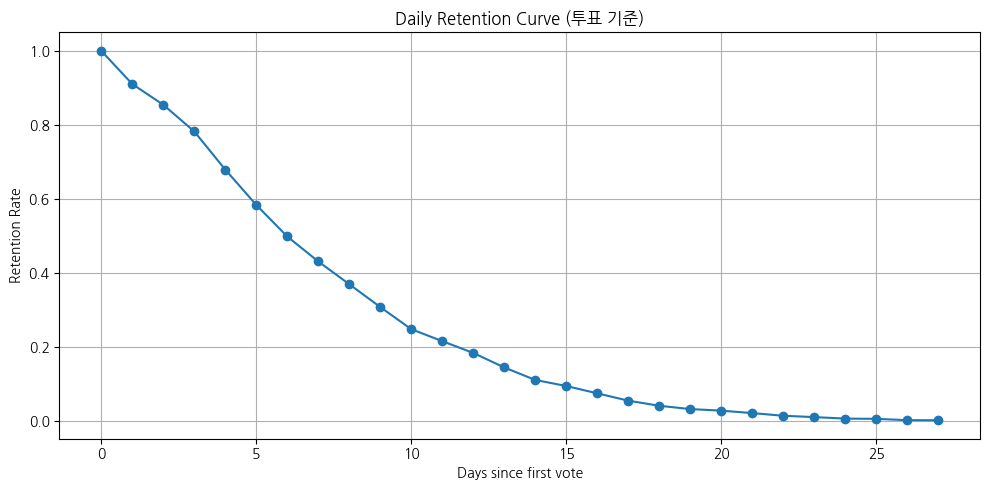

In [ ]:

plt.figure(figsize=(10, 5))
plt.plot(retention_curve['days_since_first'], retention_curve['retention_rate'], marker='o')
plt.title('Daily Retention Curve (투표 기준)')
plt.xlabel('Days since first vote')
plt.ylabel('Retention Rate')
plt.grid(True)
plt.tight_layout()
plt.show()


- Day 0: 최초 행동한 유저 수 = 4672명

- Day 1: 다음날 다시 행동한 유저 수 = 4222명 (90.37%)

- ...

- Day 9: 1397명 유지 (29.90%)

In [21]:
# 1. 날짜 형 변환
filtered_votes['vote_date'] = pd.to_datetime(filtered_votes['vote_date'])

# 2. 유저별 첫 투표일 구하기
first_vote = (
    filtered_votes.groupby('user_id')['vote_date']
    .min()
    .reset_index()
    .rename(columns={'vote_date': 'first_vote_date'})
)

# 3. Day 0이 5/1~5/25인 유저만 추출
target_users = first_vote[
    (first_vote['first_vote_date'] >= '2023-04-29') &
    (first_vote['first_vote_date'] < '2023-05-26')
]['user_id']

# 4. 이 유저들의 전체 투표 이력 확보
target_votes = filtered_votes[filtered_votes['user_id'].isin(target_users)].copy()

# 5. Day 0 정보 병합
retention_df = target_votes.merge(first_vote, on='user_id', how='left')
retention_df['days_since_first'] = (retention_df['vote_date'] - retention_df['first_vote_date']).dt.days

# 6. 하루에 한 번만 참여한 것으로 처리
retention_unique = retention_df.drop_duplicates(subset=['user_id', 'days_since_first'])

# 7. Pivot: (Day 0 날짜) x (Day N) 유저 수 테이블
cohort_pivot = retention_unique.pivot_table(
    index='first_vote_date',
    columns='days_since_first',
    values='user_id',
    aggfunc='nunique'
).fillna(0)

# 8. 리텐션율로 변환
cohort_size = cohort_pivot[0]
retention_rate = cohort_pivot.divide(cohort_size, axis=0)

# 9. 일자별 평균 리텐션율 계산
daily_retention_avg = retention_rate.mean().reset_index()
daily_retention_avg.columns = ['days_since_first', 'avg_retention_rate']

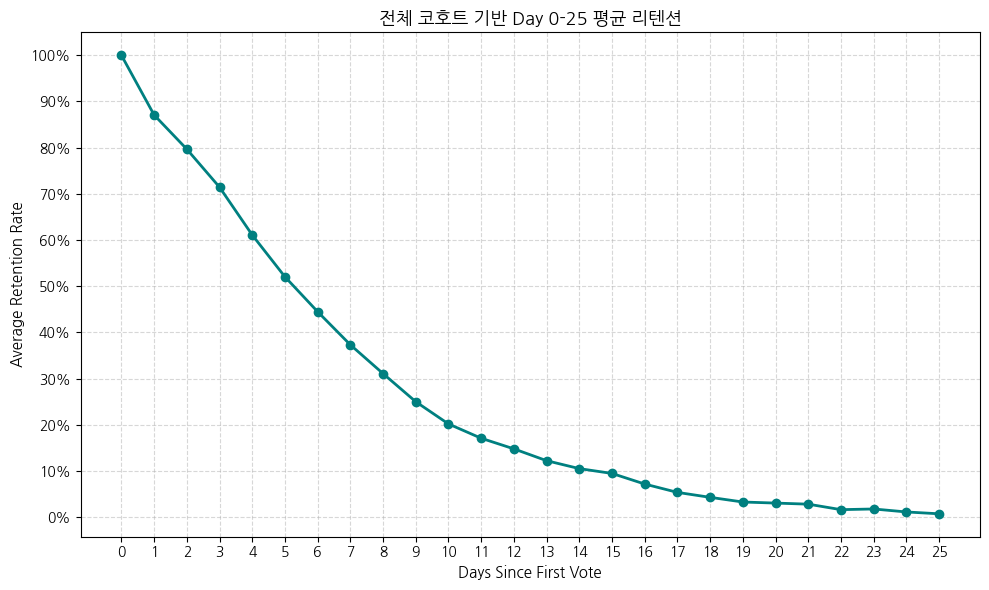

In [22]:

# 1. Day 0~25까지만 사용
plot_df = daily_retention_avg[daily_retention_avg['days_since_first'] < 26].copy()

# 2. 시각화 
plt.figure(figsize=(10, 6))
plt.plot(
    plot_df['days_since_first'],
    plot_df['avg_retention_rate'] * 100,  # 백분율로 변환
    marker='o',
    color='teal',
    linewidth=2
)

# 3. 제목 및 라벨
plt.title('전체 코호트 기반 Day 0-25 평균 리텐션', fontsize=13)
plt.xlabel('Days Since First Vote', fontsize=11)
plt.ylabel('Average Retention Rate', fontsize=11)

# 4. X축 숫자 모두 표시
plt.xticks(ticks=range(0, 26), labels=[str(i) for i in range(0, 26)])

# 5. Y축 퍼센트로 포맷 + 그리드 추가
plt.yticks(range(0, 110, 10), [f"{i}%" for i in range(0, 110, 10)])
plt.grid(True, axis='both', linestyle='--', alpha=0.5)

# 6. 여백 조정 및 출력
plt.tight_layout()
plt.show()


In [ ]:
# 1. 투표일 컬럼을 datetime.date 형식으로 보장
filtered_votes['vote_date'] = pd.to_datetime(filtered_votes['created_at']).dt.date

# 2. 유저별 첫 투표일 구하기
user_first_vote = (
    filtered_votes.groupby('user_id')['vote_date']
    .min()
    .reset_index()
    .rename(columns={'vote_date': 'first_vote_date'})
)

# 3. 날짜별 신규 유저 수 집계 (즉, 각 코호트 시작 인원 수)
cohort_new_users = (
    user_first_vote.groupby('first_vote_date')['user_id']
    .nunique()
    .reset_index(name='new_users')
)

# 4. 확인
display(cohort_new_users)


,first_vote_date,new_users
0,2023-04-28,125
1,2023-04-29,99
2,2023-04-30,114
3,2023-05-01,36
4,2023-05-02,72
5,2023-05-03,383
6,2023-05-04,167
7,2023-05-05,436
8,2023-05-06,183
9,2023-05-07,105


In [24]:
# created_at 기준 필터
vote_period_users = userquestionrecord_df[
    (userquestionrecord_df['created_at'] >= '2023-04-29') &
    (userquestionrecord_df['created_at'] < '2023-05-26')
]['user_id'].nunique()

print(f"4.29 ~ 5.25 사이 투표 기록이 있는 유저 수: {vote_period_users}")




4.29 ~ 5.25 사이 투표 기록이 있는 유저 수: 4703


In [34]:
# 4월 28일 ~ 5월 25일 사이에 투표한 유저 ID 목록
target_user_ids = userquestionrecord_df[
    (userquestionrecord_df["vote_date"] >= pd.to_datetime("2023-04-28")) &
    (userquestionrecord_df["vote_date"] <= pd.to_datetime("2023-05-25"))
]["user_id"].unique()


# 날짜를 '일' 단위로만 남김
userquestionrecord_df["vote_date"] = pd.to_datetime(userquestionrecord_df["created_at"]).dt.floor("D")

# cohort_day (유저별 첫 투표일)
cohort_df = (
    userquestionrecord_df.groupby("user_id", as_index=False)["vote_date"]
    .min()
    .rename(columns={"vote_date": "cohort_day"})
)

# ---------------- 필터링 ----------------
# 1) 대상 기간
mask_period = (cohort_df["cohort_day"].between("2023-04-29", "2023-05-25"))
period_users = set(cohort_df.loc[mask_period, "user_id"])

# 2) 4703명만
target_users = period_users & set(target_user_ids)

votes_filtered_df = userquestionrecord_df[userquestionrecord_df["user_id"].isin(target_users)].merge(
    cohort_df, on="user_id", how="left"
)

# active_day
votes_filtered_df["active_day"] = (
    votes_filtered_df["vote_date"] - votes_filtered_df["cohort_day"]
).dt.days.clip(lower=0)


In [35]:
# 코호트 크기(분모)
cohort_size = (
    votes_filtered_df.groupby("cohort_day")["user_id"]
    .nunique()
    .rename("cohort_size")
)

# active_day별 재방문(분자)
retained = (
    votes_filtered_df.groupby(["cohort_day", "active_day"])["user_id"]
    .nunique()
    .rename("retained")
)

# 비율 계산 & 피벗
retention_df = (
    retained.to_frame()
    .join(cohort_size)
    .assign(rate=lambda x: x["retained"] / x["cohort_size"])
    .reset_index()
)

retention_matrix_rate = (
    retention_df.pivot(index="cohort_day", columns="active_day", values="rate")
    .fillna(0)
    .sort_index()   # 날짜순 정렬
)


/tmp/ipykernel_3708678/1113541150.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_pct = retention_matrix_rate.applymap(lambda v: f"{v:.0%}")


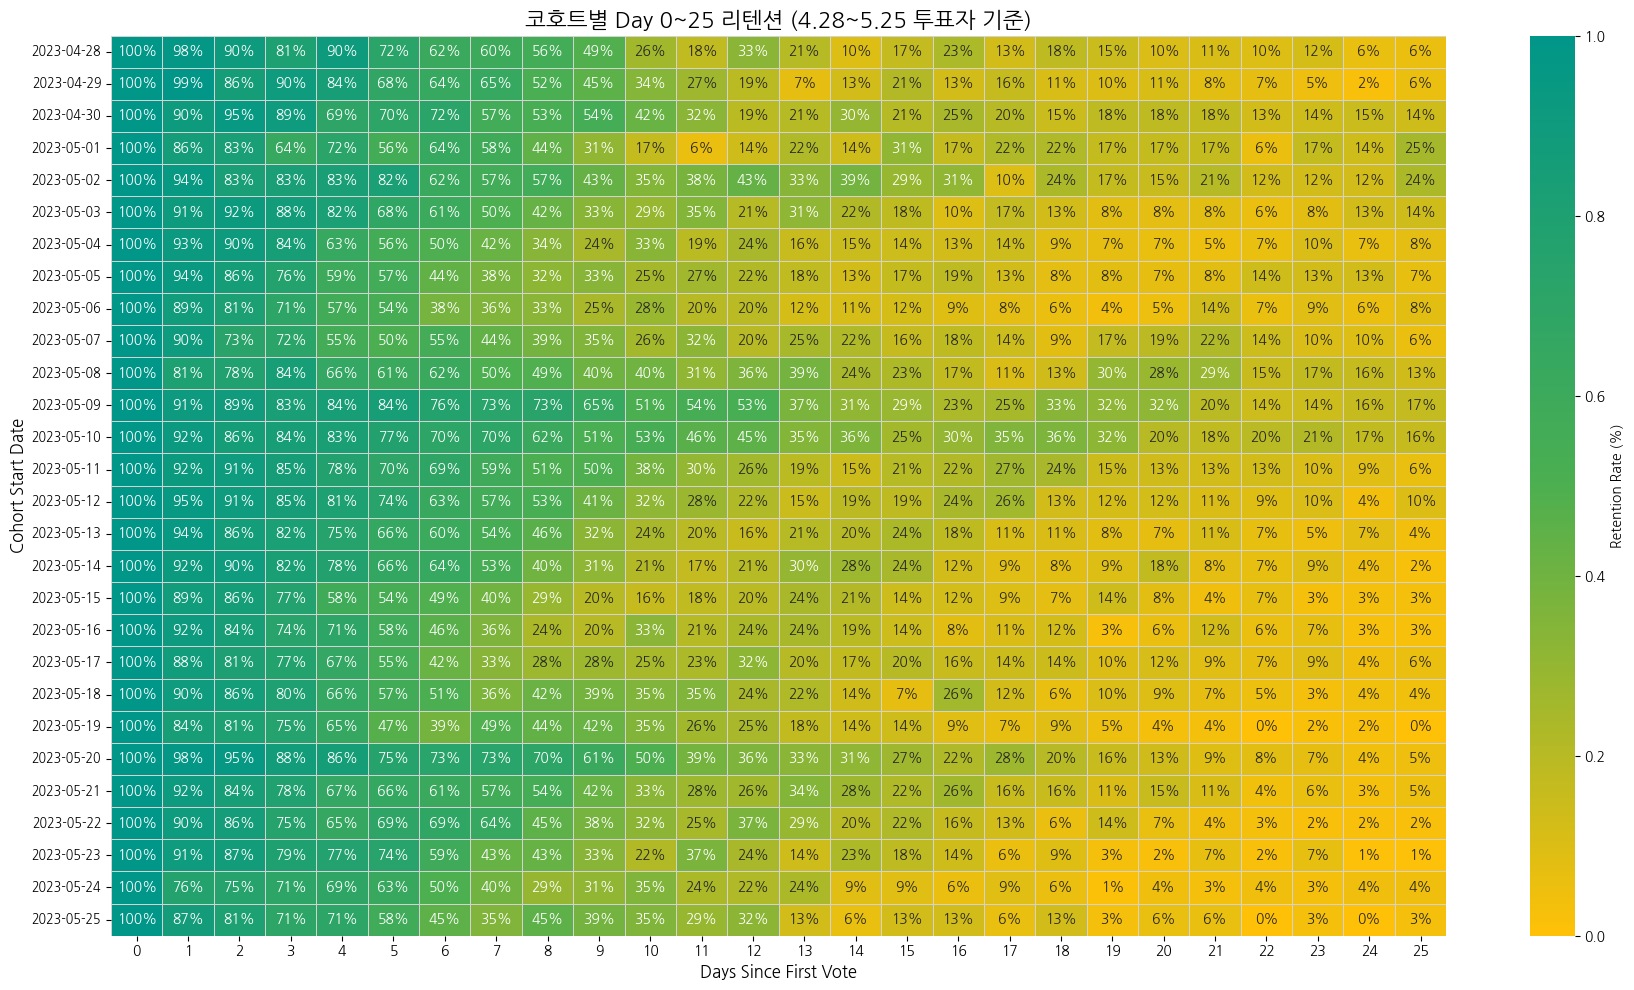

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# ✔️ 날짜 정제: y축 날짜에서 시간 제거
retention_matrix_rate.index = pd.to_datetime(retention_matrix_rate.index).date

# ✔️ x축 컬럼 제한 (Day 0~25까지만 보기)
retention_matrix_rate = retention_matrix_rate.loc[:, :25]

# ✔️ 퍼센트 문자열로 변환
annot_pct = retention_matrix_rate.applymap(lambda v: f"{v:.0%}")

# ✔️ 컬러맵 정의 (노랑 → 초록 → 청록)
custom_cmap = LinearSegmentedColormap.from_list("custom", ["#ffc107", "#4caf50", "#009688"])

# ✔️ 시각화
plt.figure(figsize=(18, 10))
sns.heatmap(
    retention_matrix_rate,
    cmap=custom_cmap,
    annot=annot_pct,
    fmt="",
    linewidths=0.5,
    linecolor="lightgray",
    cbar_kws={"label": "Retention Rate (%)"}
)

plt.title("코호트별 Day 0~25 리텐션 (4.28~5.25 투표자 기준)", fontsize=16)
plt.xlabel("Days Since First Vote", fontsize=12)
plt.ylabel("Cohort Start Date", fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()


In [29]:
import pandas as pd

# 1. 날짜 컬럼 정리
userquestionrecord_df['created_at'] = pd.to_datetime(userquestionrecord_df['created_at'])
userquestionrecord_df['vote_date'] = userquestionrecord_df['created_at'].dt.date

# 2. 필터: 4.29 ~ 5.25 사이 투표 기록이 있는 유저만 분석 대상으로 추출
vote_filtered = userquestionrecord_df[
    (userquestionrecord_df['created_at'] >= '2023-04-29') &
    (userquestionrecord_df['created_at'] < '2023-05-26')
].copy()

# 3. 유저별 첫 투표일 구하기 (코호트 기준일)
user_first_vote = (
    vote_filtered.groupby('user_id')['vote_date']
    .min()
    .reset_index()
    .rename(columns={'vote_date': 'cohort_date'})
)

# 4. 원본 데이터에 병합하여 코호트 정보 부여
retention_df = pd.merge(vote_filtered, user_first_vote, on='user_id', how='left')

# 5. days_since_first 계산 (Day 0, 1, 2, ...)
retention_df['days_since_first'] = (pd.to_datetime(retention_df['vote_date']) - pd.to_datetime(retention_df['cohort_date'])).dt.days

# 6. 중복 제거 (유저가 같은 날 여러 번 투표한 경우 제외)
retention_unique = retention_df.drop_duplicates(subset=['user_id', 'days_since_first'])

# 7. 코호트별 잔존 유저 수 집계
cohort_retention = (
    retention_unique.groupby(['cohort_date', 'days_since_first'])['user_id']
    .nunique()
    .reset_index(name='retained_users')
)

# 8. 피벗 테이블로 리텐션 매트릭스 생성
retention_matrix = cohort_retention.pivot(
    index='cohort_date',
    columns='days_since_first',
    values='retained_users'
).fillna(0).astype(int)

# 9. 비율로 환산한 리텐션 매트릭스
retention_matrix_rate = retention_matrix.div(retention_matrix[0], axis=0).round(4)

# ✅ 결과 확인
print("📊 코호트별 리텐션 행렬 (유저 수)")
display(retention_matrix.head())

print("📈 코호트별 리텐션 행렬 (비율)")
display(retention_matrix_rate.head())


📊 코호트별 리텐션 행렬 (유저 수)


days_since_first,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
cohort_date,,,,,,,,,,,,,,,,,,,,,
2023-04-29,221,211,185,200,171,143,137,134,112,78,...,38,29,23,24,20,22,13,9,16,13
2023-04-30,114,103,108,102,79,80,82,65,60,62,...,23,17,21,21,20,15,16,17,16,0
2023-05-01,37,32,31,23,26,20,23,21,16,11,...,8,9,6,6,6,2,6,5,0,0
2023-05-02,73,68,60,60,60,59,45,41,41,31,...,7,17,12,11,15,9,9,0,0,0
2023-05-03,384,348,354,336,315,262,234,193,162,127,...,65,50,30,29,30,23,0,0,0,0


📈 코호트별 리텐션 행렬 (비율)


days_since_first,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
cohort_date,,,,,,,,,,,,,,,,,,,,,
2023-04-29,1.0,0.9548,0.8371,0.9050,0.7738,0.6471,0.6199,0.6063,0.5068,0.3529,...,0.1719,0.1312,0.1041,0.1086,0.0905,0.0995,0.0588,0.0407,0.0724,0.0588
2023-04-30,1.0,0.9035,0.9474,0.8947,0.6930,0.7018,0.7193,0.5702,0.5263,0.5439,...,0.2018,0.1491,0.1842,0.1842,0.1754,0.1316,0.1404,0.1491,0.1404,0.0000
2023-05-01,1.0,0.8649,0.8378,0.6216,0.7027,0.5405,0.6216,0.5676,0.4324,0.2973,...,0.2162,0.2432,0.1622,0.1622,0.1622,0.0541,0.1622,0.1351,0.0000,0.0000
2023-05-02,1.0,0.9315,0.8219,0.8219,0.8219,0.8082,0.6164,0.5616,0.5616,0.4247,...,0.0959,0.2329,0.1644,0.1507,0.2055,0.1233,0.1233,0.0000,0.0000,0.0000
2023-05-03,1.0,0.9062,0.9219,0.8750,0.8203,0.6823,0.6094,0.5026,0.4219,0.3307,...,0.1693,0.1302,0.0781,0.0755,0.0781,0.0599,0.0000,0.0000,0.0000,0.0000


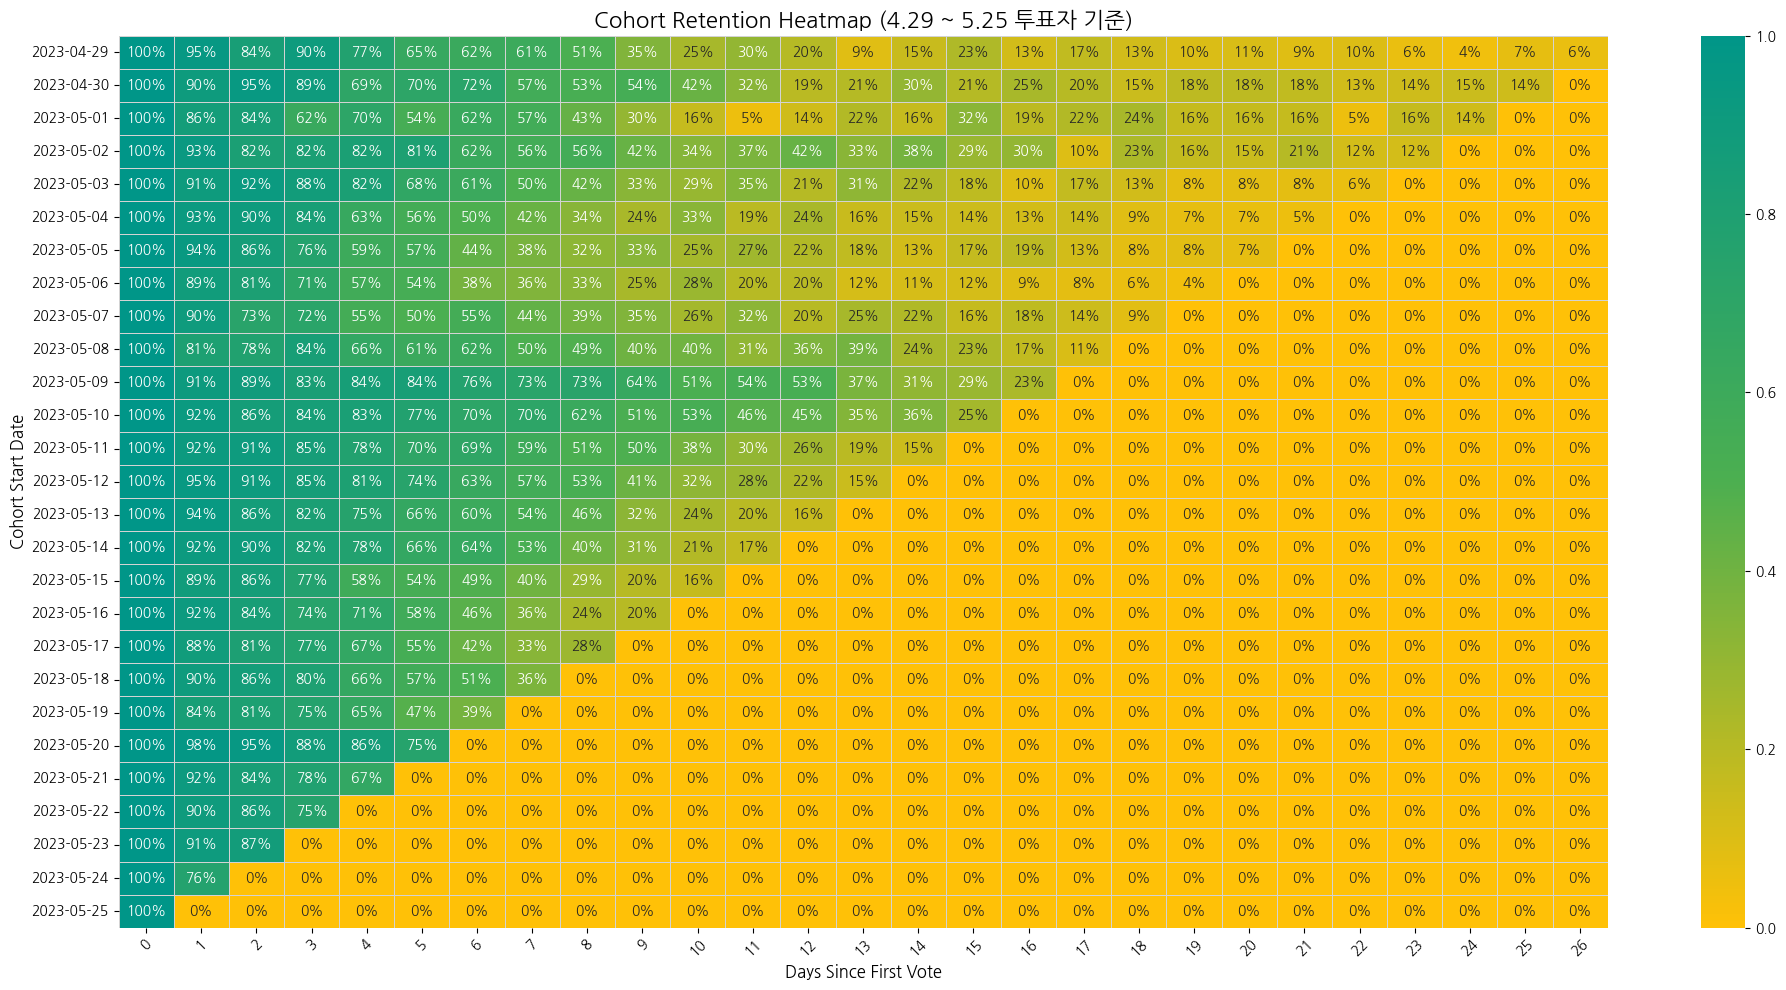

In [33]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 사용자 정의 컬러맵 (노랑 → 초록 → 청록)
custom_cmap = LinearSegmentedColormap.from_list(
    "custom", ["#ffc107", "#4caf50", "#009688"]
)

# 2. 히트맵 그리기 (여기서 cmap 변수 그대로 전달!)
plt.figure(figsize=(20, 10))

sns.heatmap(
    retention_matrix_rate,     # 퍼센트 값 (0.0 ~ 1.0 범위)
    cmap=custom_cmap,          # 문자열이 아닌 실제 객체!
    annot=True,
    fmt='.0%',                 # 퍼센트 포맷
    cbar=True,
    linewidths=0.5,
    linecolor='lightgray'
)

plt.title("Cohort Retention Heatmap (4.29 ~ 5.25 투표자 기준)", fontsize=16)
plt.xlabel("Days Since First Vote", fontsize=12)
plt.ylabel("Cohort Start Date", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [27]:
retention_df.columns

Index(['id', 'status', 'created_at', 'chosen_user_id', 'question_id',
       'user_id', 'question_piece_id', 'has_read', 'answer_status',
       'answer_updated_at', 'report_count', 'opened_times', 'vote_date',
       'cohort_date', 'days_since_first'],
      dtype='object')

In [28]:
print(retention_df.columns.tolist())

['id', 'status', 'created_at', 'chosen_user_id', 'question_id', 'user_id', 'question_piece_id', 'has_read', 'answer_status', 'answer_updated_at', 'report_count', 'opened_times', 'vote_date', 'cohort_date', 'days_since_first']


In [29]:
# 1. 유저별 첫 투표일 추출
user_first_vote = (
    filtered_votes.groupby('user_id')['vote_date']
    .min()
    .reset_index()
    .rename(columns={'vote_date': 'first_vote_date'})
)

# 2. 기존 투표 기록과 병합 → 유저가 어떤 코호트(첫날)에 속했는지 알 수 있음
retention_df = filtered_votes.merge(user_first_vote, on='user_id', how='left')

# 3. days_since_first 계산 (Day 0, Day 1, ...)
retention_df['vote_date'] = pd.to_datetime(retention_df['vote_date'])
retention_df['first_vote_date'] = pd.to_datetime(retention_df['first_vote_date'])
retention_df['days_since_first'] = (retention_df['vote_date'] - retention_df['first_vote_date']).dt.days

# 4. 중복 제거 (같은 날 여러 번 투표한 건 제외)
retention_unique = retention_df.drop_duplicates(subset=['user_id', 'days_since_first'])

# 5. 코호트별 N일 후 유저 수 집계
cohort_retention = (
    retention_unique.groupby(['first_vote_date', 'days_since_first'])['user_id']
    .nunique()
    .reset_index(name='retained_users')
)

# 6. 피벗 → 매트릭스 형태로 변환
retention_matrix = cohort_retention.pivot(
    index='first_vote_date',
    columns='days_since_first',
    values='retained_users'
).fillna(0).astype(int)

# 7. 비율화
retention_matrix_rate = retention_matrix.div(retention_matrix[0], axis=0).round(4)

# 결과 확인
display(retention_matrix.head())
display(retention_matrix_rate.head())

days_since_first,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
first_vote_date,,,,,,,,,,,,,,,,,,,,,
2023-04-28,125,122,113,101,113,90,77,75,70,61,...,23,19,13,14,12,15,8,7,10,11
2023-04-29,99,98,85,89,83,67,63,64,51,45,...,11,10,11,8,7,5,2,6,2,0
2023-04-30,114,103,108,102,79,80,82,65,60,62,...,17,21,21,20,15,16,17,16,0,0
2023-05-01,36,31,30,23,26,20,23,21,16,11,...,8,6,6,6,2,6,5,0,0,0
2023-05-02,72,68,60,60,60,59,45,41,41,31,...,17,12,11,15,9,9,0,0,0,0


days_since_first,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
first_vote_date,,,,,,,,,,,,,,,,,,,,,
2023-04-28,1.0,0.9760,0.9040,0.8080,0.9040,0.7200,0.6160,0.6000,0.5600,0.4880,...,0.1840,0.1520,0.1040,0.1120,0.0960,0.1200,0.0640,0.0560,0.0800,0.088
2023-04-29,1.0,0.9899,0.8586,0.8990,0.8384,0.6768,0.6364,0.6465,0.5152,0.4545,...,0.1111,0.1010,0.1111,0.0808,0.0707,0.0505,0.0202,0.0606,0.0202,0.000
2023-04-30,1.0,0.9035,0.9474,0.8947,0.6930,0.7018,0.7193,0.5702,0.5263,0.5439,...,0.1491,0.1842,0.1842,0.1754,0.1316,0.1404,0.1491,0.1404,0.0000,0.000
2023-05-01,1.0,0.8611,0.8333,0.6389,0.7222,0.5556,0.6389,0.5833,0.4444,0.3056,...,0.2222,0.1667,0.1667,0.1667,0.0556,0.1667,0.1389,0.0000,0.0000,0.000
2023-05-02,1.0,0.9444,0.8333,0.8333,0.8333,0.8194,0.6250,0.5694,0.5694,0.4306,...,0.2361,0.1667,0.1528,0.2083,0.1250,0.1250,0.0000,0.0000,0.0000,0.000


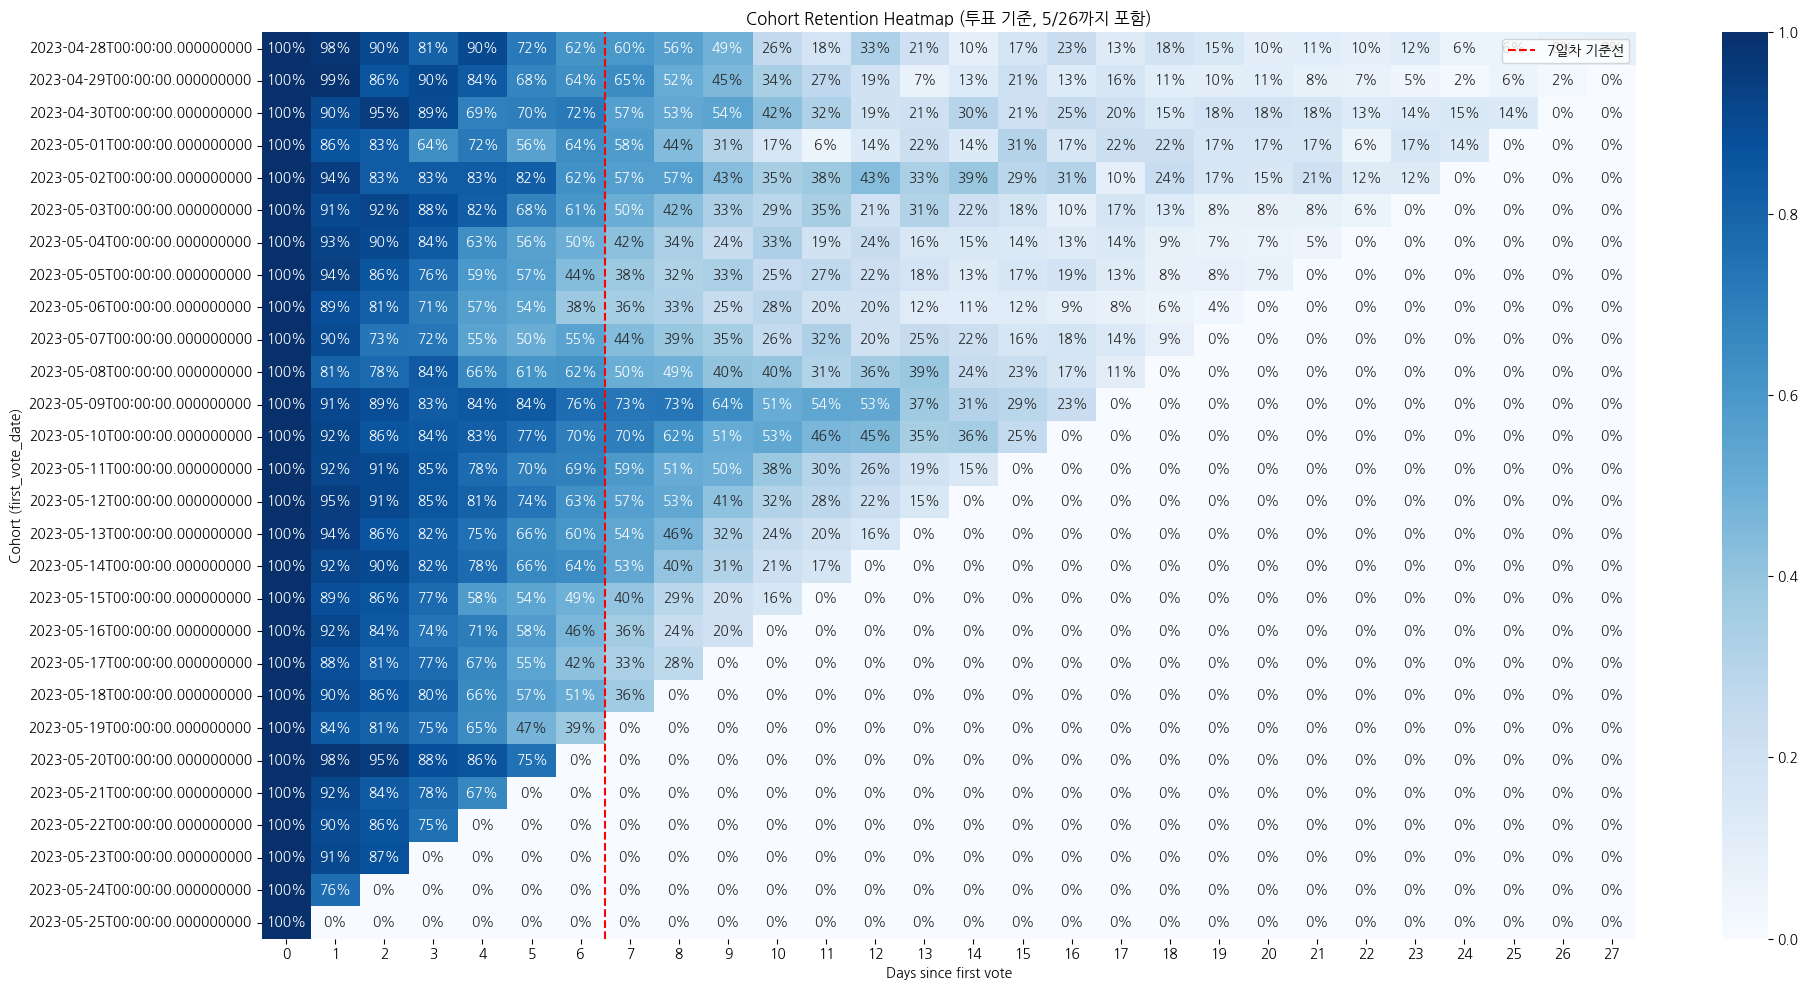

In [30]:

plt.figure(figsize=(20, 10))
ax = sns.heatmap(retention_matrix_rate, cmap="Blues", annot=True, fmt=".0%", cbar=True)

# 보조선 추가: Day 7을 넘기지 않는 기준선
plt.axvline(x=7, color='red', linestyle='--', label='7일차 기준선')
plt.title("Cohort Retention Heatmap (투표 기준, 5/26까지 포함)")
plt.xlabel("Days since first vote")
plt.ylabel("Cohort (first_vote_date)")
plt.legend()
plt.tight_layout()
plt.show()


In [31]:
# 1. 분석 기준일
cutoff_date = pd.to_datetime('2023-05-26')

# 2. 가능한 일차만 남기기: 각 코호트 + days_since_first <= 2023-05-26
valid_retention = retention_matrix_rate.copy()
valid_index = valid_retention.index

# 반복적으로 각 행(코호트)의 가능한 max day 계산
for cohort_date in valid_index:
    max_valid_day = (cutoff_date - cohort_date).days
    if max_valid_day < 0:
        # 아직 시작도 안 한 코호트면 전체 삭제
        valid_retention.drop(index=cohort_date, inplace=True)
    else:
        # 가능한 day만 유지
        cols_to_zero = [col for col in valid_retention.columns if col > max_valid_day]
        valid_retention.loc[cohort_date, cols_to_zero] = 0

# 결과 확인
display(valid_retention.head())



days_since_first,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
first_vote_date,,,,,,,,,,,,,,,,,,,,,
2023-04-28,1.0,0.9760,0.9040,0.8080,0.9040,0.7200,0.6160,0.6000,0.5600,0.4880,...,0.1840,0.1520,0.1040,0.1120,0.0960,0.1200,0.0640,0.0560,0.0800,0.088
2023-04-29,1.0,0.9899,0.8586,0.8990,0.8384,0.6768,0.6364,0.6465,0.5152,0.4545,...,0.1111,0.1010,0.1111,0.0808,0.0707,0.0505,0.0202,0.0606,0.0202,0.000
2023-04-30,1.0,0.9035,0.9474,0.8947,0.6930,0.7018,0.7193,0.5702,0.5263,0.5439,...,0.1491,0.1842,0.1842,0.1754,0.1316,0.1404,0.1491,0.1404,0.0000,0.000
2023-05-01,1.0,0.8611,0.8333,0.6389,0.7222,0.5556,0.6389,0.5833,0.4444,0.3056,...,0.2222,0.1667,0.1667,0.1667,0.0556,0.1667,0.1389,0.0000,0.0000,0.000
2023-05-02,1.0,0.9444,0.8333,0.8333,0.8333,0.8194,0.6250,0.5694,0.5694,0.4306,...,0.2361,0.1667,0.1528,0.2083,0.1250,0.1250,0.0000,0.0000,0.0000,0.000


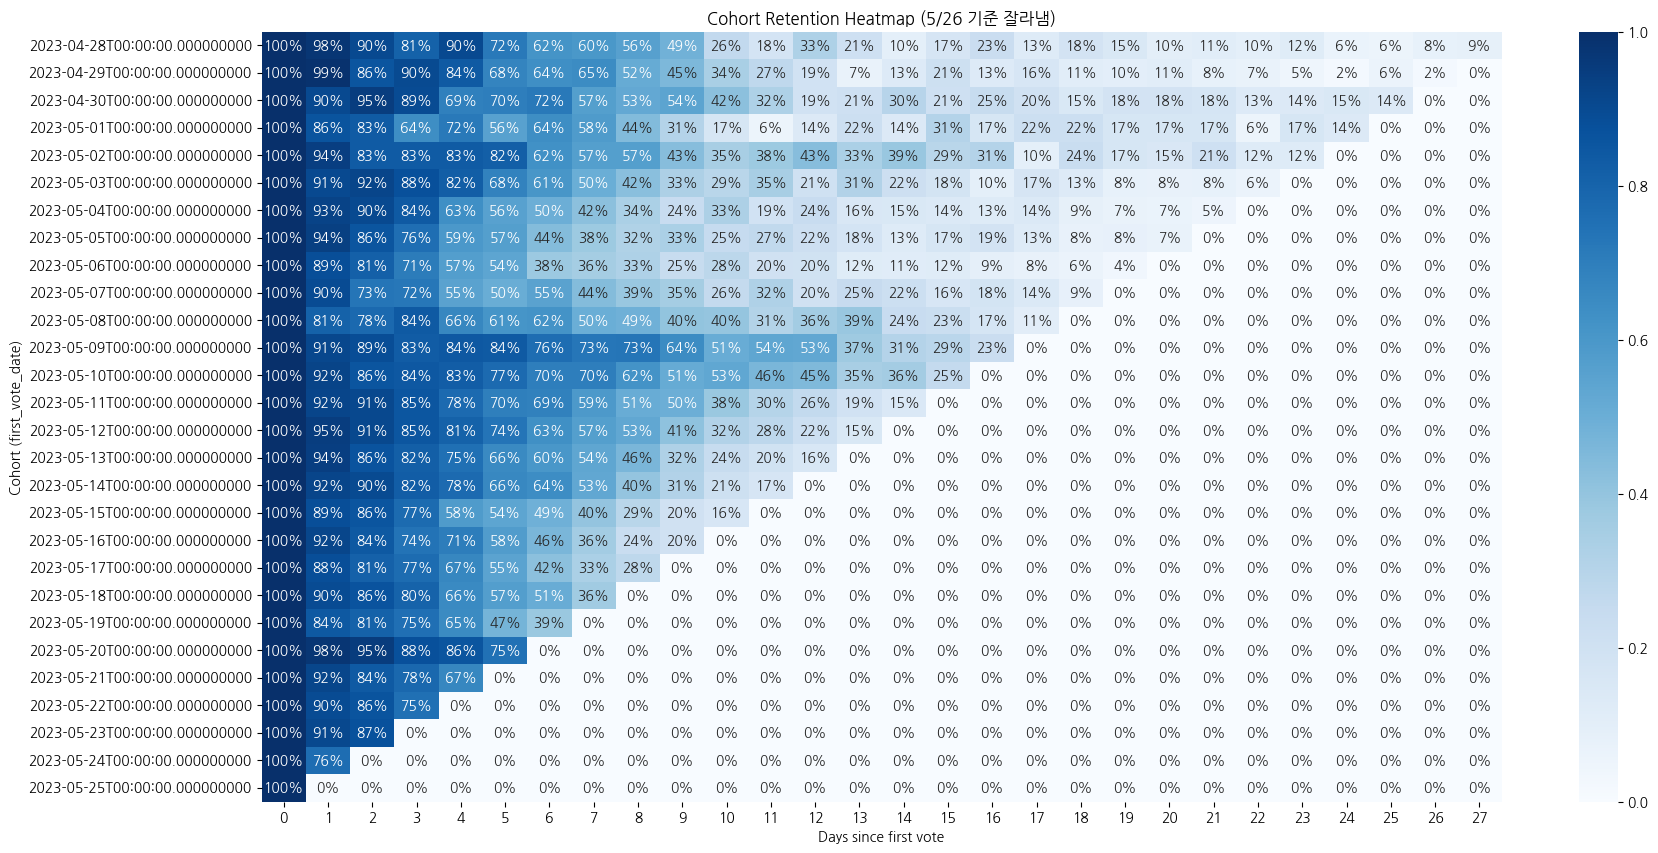

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
sns.heatmap(valid_retention, cmap="Blues", annot=True, fmt=".0%", cbar=True)
plt.title("Cohort Retention Heatmap (5/26 기준 잘라냄)")
plt.xlabel("Days since first vote")
plt.ylabel("Cohort (first_vote_date)")
plt.show()


### 4월 29일 ~ 5월 25일 코호트까지만

In [33]:
# 1. 유저별 최초 투표일 계산 (코호트 기준)
user_first_vote = (
    filtered_votes.groupby('user_id')['vote_date']
    .min()
    .reset_index()
    .rename(columns={'vote_date': 'first_vote_date'})
)

# 2. 병합하여 코호트 정보 부여
retention_df = filtered_votes.merge(user_first_vote, on='user_id', how='left')

# 3. 날짜 차이 계산
retention_df['vote_date'] = pd.to_datetime(retention_df['vote_date'])
retention_df['first_vote_date'] = pd.to_datetime(retention_df['first_vote_date'])
retention_df['days_since_first'] = (retention_df['vote_date'] - retention_df['first_vote_date']).dt.days

# 4. 중복 제거 (유저가 특정 일자에 중복 투표했더라도 1건만 카운트)
retention_unique = retention_df.drop_duplicates(subset=['user_id', 'days_since_first'])

# 5. 5월 1일 ~ 5월 25일 사이의 코호트만 필터링
retention_unique = retention_unique[
    (retention_unique['first_vote_date'] >= '2023-04-29') &
    (retention_unique['first_vote_date'] < '2023-05-26')
]

# 6. 코호트별 잔존 유저 수 집계
cohort_retention = (
    retention_unique.groupby(['first_vote_date', 'days_since_first'])['user_id']
    .nunique()
    .reset_index(name='retained_users')
)

# 7. 피벗 테이블 (매트릭스 형태)
retention_matrix = cohort_retention.pivot(
    index='first_vote_date',
    columns='days_since_first',
    values='retained_users'
).fillna(0).astype(int)

# 8. (선택) 리텐션율 계산
retention_matrix_rate = retention_matrix.div(retention_matrix[0], axis=0).round(4)

# 9. 결과 확인
display(retention_matrix.head())
display(retention_matrix_rate.head())


days_since_first,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
first_vote_date,,,,,,,,,,,,,,,,,,,,,
2023-04-29,99,98,85,89,83,67,63,64,51,45,...,16,11,10,11,8,7,5,2,6,2
2023-04-30,114,103,108,102,79,80,82,65,60,62,...,23,17,21,21,20,15,16,17,16,0
2023-05-01,36,31,30,23,26,20,23,21,16,11,...,8,8,6,6,6,2,6,5,0,0
2023-05-02,72,68,60,60,60,59,45,41,41,31,...,7,17,12,11,15,9,9,0,0,0
2023-05-03,383,347,353,336,315,262,233,192,162,127,...,65,50,30,29,30,23,0,0,0,0


days_since_first,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
first_vote_date,,,,,,,,,,,,,,,,,,,,,
2023-04-29,1.0,0.9899,0.8586,0.8990,0.8384,0.6768,0.6364,0.6465,0.5152,0.4545,...,0.1616,0.1111,0.1010,0.1111,0.0808,0.0707,0.0505,0.0202,0.0606,0.0202
2023-04-30,1.0,0.9035,0.9474,0.8947,0.6930,0.7018,0.7193,0.5702,0.5263,0.5439,...,0.2018,0.1491,0.1842,0.1842,0.1754,0.1316,0.1404,0.1491,0.1404,0.0000
2023-05-01,1.0,0.8611,0.8333,0.6389,0.7222,0.5556,0.6389,0.5833,0.4444,0.3056,...,0.2222,0.2222,0.1667,0.1667,0.1667,0.0556,0.1667,0.1389,0.0000,0.0000
2023-05-02,1.0,0.9444,0.8333,0.8333,0.8333,0.8194,0.6250,0.5694,0.5694,0.4306,...,0.0972,0.2361,0.1667,0.1528,0.2083,0.1250,0.1250,0.0000,0.0000,0.0000
2023-05-03,1.0,0.9060,0.9217,0.8773,0.8225,0.6841,0.6084,0.5013,0.4230,0.3316,...,0.1697,0.1305,0.0783,0.0757,0.0783,0.0601,0.0000,0.0000,0.0000,0.0000


### 재투표 유저들

In [34]:
# Step 1: Day 1 이상에 재투표한 user_id 목록 추출
repeat_voters = retention_df[retention_df['days_since_first'] >= 1]['user_id'].unique()

print(f"재투표한 유저 수: {len(repeat_voters)}")


재투표한 유저 수: 4522


In [35]:
# Step 2: 재투표 유저들의 전체 기록 보기
repeat_vote_logs = retention_df[retention_df['user_id'].isin(repeat_voters)]

# 확인
display(repeat_vote_logs.head())


,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times,gender,school_id,user_id_question,created_at_question,status_question,vote_date,first_vote_date,days_since_first
0,771777,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,0,0,F,271.0,NaN,NaT,NaN,2023-04-28,2023-04-28,0
1,771800,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,0,0,F,271.0,NaN,NaT,NaN,2023-04-28,2023-04-28,0
2,771812,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,0,0,F,271.0,NaN,NaT,NaN,2023-04-28,2023-04-28,0
3,771828,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,0,0,F,271.0,NaN,NaT,NaN,2023-04-28,2023-04-28,0
4,771851,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,0,0,F,271.0,NaN,NaT,NaN,2023-04-28,2023-04-28,0


In [36]:
# Step 3: 유저별 재투표 횟수 집계 (Day 1 이상)
repeat_vote_counts = (
    retention_df[retention_df['days_since_first'] >= 1]
    .groupby('user_id')['days_since_first']
    .count()
    .reset_index(name='repeat_vote_count')
    .sort_values(by='repeat_vote_count', ascending=False)
)

display(repeat_vote_counts)


,user_id,repeat_vote_count
783,876509,1663
20,849103,1541
3164,1213990,1429
3087,1206529,1352
540,873568,1296
...,...,...
1163,884945,1
686,875330,1
1629,916061,1
1580,905865,1


### 두 집단간에 차이가 있는 지표

In [37]:
# 1. 질문 카테고리 테이블 불러오기
question_df = pd.read_parquet('gs://final_project_enuyu/data/final_project/votes/polls_question_add_category.parquet')

# 컬럼 확인
print(question_df.columns)

Index(['id', 'question_text', 'created_at', 'category'], dtype='object')


In [38]:

merged_df = userquestionrecord_df.merge(
    question_df[['id', 'category']],
    left_on='question_id',
    right_on='id',
    how='left'
)


In [39]:
# retention_df 생성 및 days_since_first 계산
retention_df = userquestionrecord_df.merge(first_vote, on='user_id', how='left')
retention_df['days_since_first'] = (
    retention_df['created_at'] - retention_df['first_vote_date']
).dt.days

In [40]:


# ─────────────────────────────────────────────
# 0. 분석 기간 상수
# ─────────────────────────────────────────────
DATE_FROM = pd.Timestamp('2023-04-29')
DATE_TO   = pd.Timestamp('2023-05-25')

# ─────────────────────────────────────────────
# 1. 유저별 최초 투표일
# ─────────────────────────────────────────────
first_vote = (
    userquestionrecord_df.groupby('user_id')['created_at']
    .min()
    .reset_index()
    .rename(columns={'created_at': 'first_vote_date'})
)

# ─────────────────────────────────────────────
# 2. 병합 및 days_since_first 계산
# ─────────────────────────────────────────────
retention_df = userquestionrecord_df.merge(first_vote, on='user_id', how='left')
retention_df['days_since_first'] = (
    retention_df['created_at'] - retention_df['first_vote_date']
).dt.days

# 👉 **여기서 기간 필터 추가 (핵심)**
retention_df = retention_df[
    (retention_df['first_vote_date'] >= DATE_FROM) &
    (retention_df['first_vote_date'] <= DATE_TO)
]

# ─────────────────────────────────────────────
# 3. 질문 카테고리 병합
# ─────────────────────────────────────────────
question_df = question_df.rename(columns={'id': 'question_id'})
retention_df = retention_df.merge(
    question_df[['question_id', 'category']],
    on='question_id',
    how='left'
)

# 4. category가 배열이면 첫 번째 값만 사용
retention_df['category'] = retention_df['category'].apply(
    lambda x: x[0] if isinstance(x, (list, np.ndarray)) and len(x) else x
)

# ─────────────────────────────────────────────
# 5. Day 0 / Day 7 추출
# ─────────────────────────────────────────────
day0 = retention_df[retention_df['days_since_first'] == 0]
day7 = retention_df[retention_df['days_since_first'] == 7]

# ─────────────────────────────────────────────
# 6. category별 유저 수 & 리텐션율
# ─────────────────────────────────────────────
day0_user = (
    day0.groupby('category')['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'user_id': 'day0_users'})
)

day7_user = (
    day7.groupby('category')['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'user_id': 'day7_users'})
)

category_retention = (
    pd.merge(day0_user, day7_user, on='category', how='left')
      .fillna(0)
)
category_retention['day7_retention_rate'] = (
    category_retention['day7_users'] / category_retention['day0_users']
)

category_retention = category_retention.sort_values(
    'day7_retention_rate', ascending=False
).reset_index(drop=True)

category_retention


,category,day0_users,day7_users,day7_retention_rate
0,일상,4496,2137,0.475311
1,심리,4385,1965,0.448119
2,연애,4036,1595,0.395193
3,성격,4157,1632,0.392591
4,생존,275,94,0.341818
5,상상,1785,465,0.260504
6,미디어,2260,565,0.250000
7,감성,514,126,0.245136
8,미래,2790,588,0.210753
9,관찰,1142,209,0.183012


/tmp/ipykernel_3642790/698583940.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Greys')  # 'Greys' 컬러맵은 0=흰색 ~ 1=검정이므로 거꾸로 씀


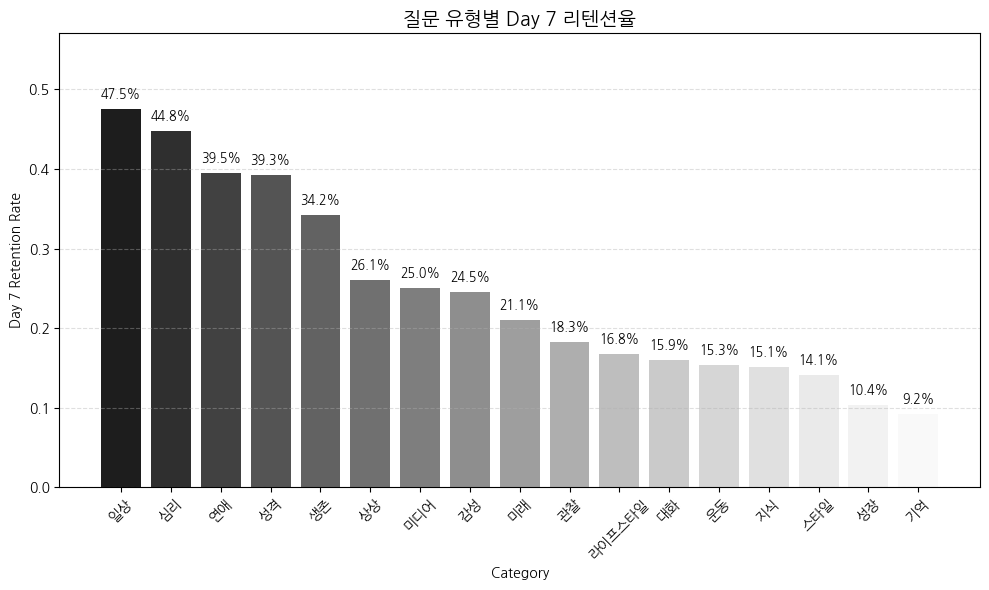

In [41]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# 1. 데이터 준비
labels = category_retention['category']
values = category_retention['day7_retention_rate']

# 2. 색상 팔레트: 검정 → 밝은 회색으로 점점 연해짐
cmap = cm.get_cmap('Greys')  # 'Greys' 컬러맵은 0=흰색 ~ 1=검정이므로 거꾸로 씀
colors = [cmap(0.9 - i * 0.9 / len(values)) for i in range(len(values))]

# 3. 시각화
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=colors)

# 4. 값 표시 (막대 위에 %로)
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01,
        f'{height*100:.1f}%',
        ha='center',
        va='bottom',
        fontsize=9
    )

# 5. 레이아웃 설정
plt.title('질문 유형별 Day 7 리텐션율', fontsize=14)
plt.xlabel('Category')
plt.ylabel('Day 7 Retention Rate')
plt.xticks(rotation=45)
plt.ylim(0, max(values)*1.2)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


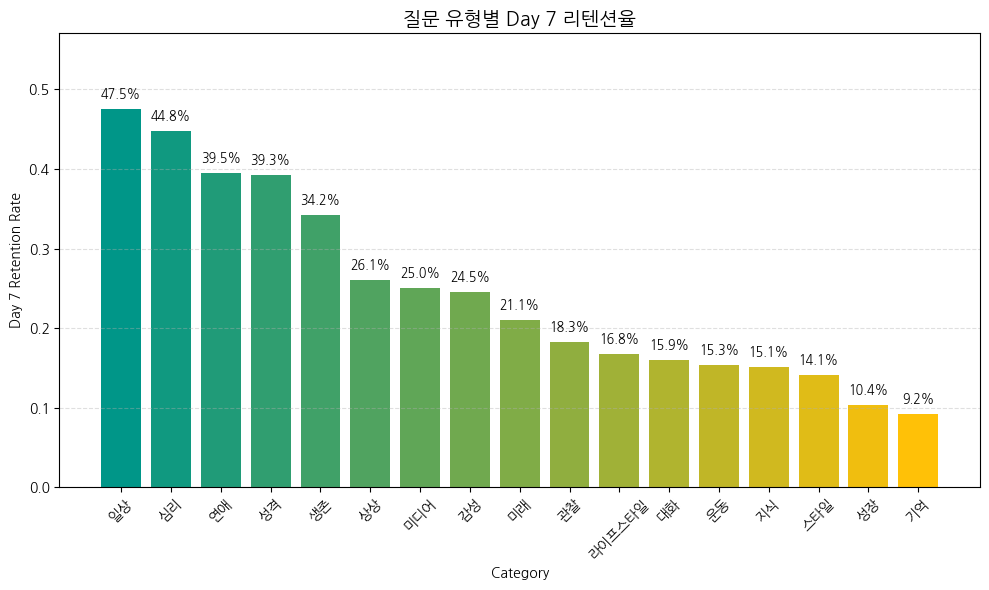

In [42]:

import matplotlib.colors as mcolors

# 1. 데이터 준비
labels = category_retention['category']
values = category_retention['day7_retention_rate']

# 2. 커스텀 그라데이션 컬러 팔레트 생성
cmap = mcolors.LinearSegmentedColormap.from_list("custom_gradient", ['#009688', '#ffc107'])
colors = [cmap(i / (len(values) - 1)) for i in range(len(values))]

# 3. 시각화
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=colors)

# 4. 막대 위에 비율 값 표시
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01,
        f'{height*100:.1f}%',
        ha='center',
        va='bottom',
        fontsize=9
    )

# 5. 레이아웃 설정
plt.title('질문 유형별 Day 7 리텐션율', fontsize=14)
plt.xlabel('Category')
plt.ylabel('Day 7 Retention Rate')
plt.xticks(rotation=45)
plt.ylim(0, max(values) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [43]:
day0_user

,category,day0_users
0,감성,514
1,관찰,1142
2,기억,424
3,대화,715
4,라이프스타일,1295
5,미디어,2260
6,미래,2790
7,상상,1785
8,생존,275
9,성격,4157


In [44]:
day7_user

,category,day7_users
0,감성,126
1,관찰,209
2,기억,39
3,대화,114
4,라이프스타일,217
5,미디어,565
6,미래,588
7,상상,465
8,생존,94
9,성격,1632


In [45]:
import datetime


# ─────────────────────────────────────────────
# 0. 리텐션 기간(2023-04-29 ~ 2023-05-25) 필터
# ─────────────────────────────────────────────
DATE_FROM = pd.Timestamp('2023-04-29')
DATE_TO   = pd.Timestamp('2023-05-25')

# ─────────────────────────────────────────────
# 1. 유저별 최초 투표일(first_vote_date) 계산
# ─────────────────────────────────────────────
first_vote = (
    userquestionrecord_df.groupby('user_id', as_index=False)['created_at']
    .min()
    .rename(columns={'created_at': 'first_vote_date'})
)

# ─────────────────────────────────────────────
# 2. 투표 로그 + 최초투표일 병합 → days_since_first
#    + 리텐션 기간으로 한 번 더 필터
# ─────────────────────────────────────────────
retention_df = (
    userquestionrecord_df
    .merge(first_vote, on='user_id', how='left')
)
retention_df['days_since_first'] = (
    retention_df['created_at'] - retention_df['first_vote_date']
).dt.days

retention_df = retention_df[
    (retention_df['first_vote_date'] >= DATE_FROM) &
    (retention_df['first_vote_date'] <= DATE_TO)
]

# ─────────────────────────────────────────────
# 3. 질문 카테고리 병합
# ─────────────────────────────────────────────
question_df = question_df.rename(columns={'id': 'question_id'})
retention_df = retention_df.merge(
    question_df[['question_id', 'category']],
    on='question_id',
    how='left'
)

# category 값이 배열이면 첫 번째 값만 추출
retention_df['category'] = retention_df['category'].apply(
    lambda x: x[0] if isinstance(x, (list, np.ndarray)) and len(x) else x
)

# ─────────────────────────────────────────────
# 4. Day-0 레코드만 추출 → day0_df
# ─────────────────────────────────────────────
day0_df = retention_df[retention_df['days_since_first'] == 0].copy()
day0_df['first_vote_hour'] = day0_df['created_at'].dt.hour

# 계정 메타(gender / group_id) 붙이기
day0_df = day0_df.merge(
    user_df[['id', 'gender', 'group_id']],
    left_on='user_id',      # ← 조인 키 수정
    right_on='id',
    how='left'
)

# 날짜 열을 date 타입으로 변환
day0_df['first_vote_date'] = day0_df['first_vote_date'].dt.date

# ─────────────────────────────────────────────
# 5. 두 코호트(높음·낮음) 분리
# ─────────────────────────────────────────────
high_date = datetime.date(2023, 5, 20)
low_date  = datetime.date(2023, 5, 17)

high_cohort = day0_df[day0_df['first_vote_date'] == high_date]
low_cohort  = day0_df[day0_df['first_vote_date'] == low_date]

print(f'High cohort size : {high_cohort["user_id"].nunique()}')
print(f'Low  cohort size : {low_cohort["user_id"].nunique()}')

# ─────────────────────────────────────────────
# 6. 범주형 컬럼별 비율 차이 함수
# ─────────────────────────────────────────────
def diff_table(df_high, df_low, col):
    h = df_high[col].value_counts(normalize=True)
    l = df_low[col].value_counts(normalize=True)
    joined = pd.concat([h, l], axis=1, keys=['high', 'low']).fillna(0)
    joined['diff_pct'] = (joined['high'] - joined['low']).abs() * 100
    joined['feature']  = col
    joined['category'] = joined.index
    return joined.reset_index(drop=True)

# 비교할 범주형 컬럼
cat_vars = ['category', 'first_vote_hour', 'gender', 'group_id']

# 모든 컬럼에 대해 diff 구해 합치기
out = pd.concat(
    [diff_table(high_cohort, low_cohort, c) for c in cat_vars],
    ignore_index=True
)

# 차이 큰 순 Top-N
top_diff = out.sort_values('diff_pct', ascending=False)

# ─────────────────────────────────────────────
# 7. 결과 출력
# ─────────────────────────────────────────────
print(top_diff[['feature', 'category', 'high', 'low', 'diff_pct']].head(15))


High cohort size : 163
Low  cohort size : 69
     feature category      high       low   diff_pct
43  group_id  11843.0  0.126574  0.000000  12.657364
44  group_id  53266.0  0.104126  0.000000  10.412559
69  group_id  63325.0  0.007280  0.090487   8.320679
45  group_id  44748.0  0.082739  0.000000   8.273927
86  group_id  16231.0  0.000000  0.069896   6.989559
46  group_id  55764.0  0.064614  0.000000   6.461398
47  group_id  56013.0  0.055741  0.000000   5.574094
48  group_id  68957.0  0.052859  0.000000   5.285909
87  group_id  56038.0  0.000000  0.048434   4.843387
49  group_id  39419.0  0.047702  0.000000   4.770211
42    gender        M  0.450705  0.492459   4.175410
41    gender        F  0.549295  0.507541   4.175410
50  group_id   5545.0  0.038298  0.000000   3.829820
88  group_id  47812.0  0.000000  0.037993   3.799304
51  group_id  70489.0  0.037843  0.000000   3.784317


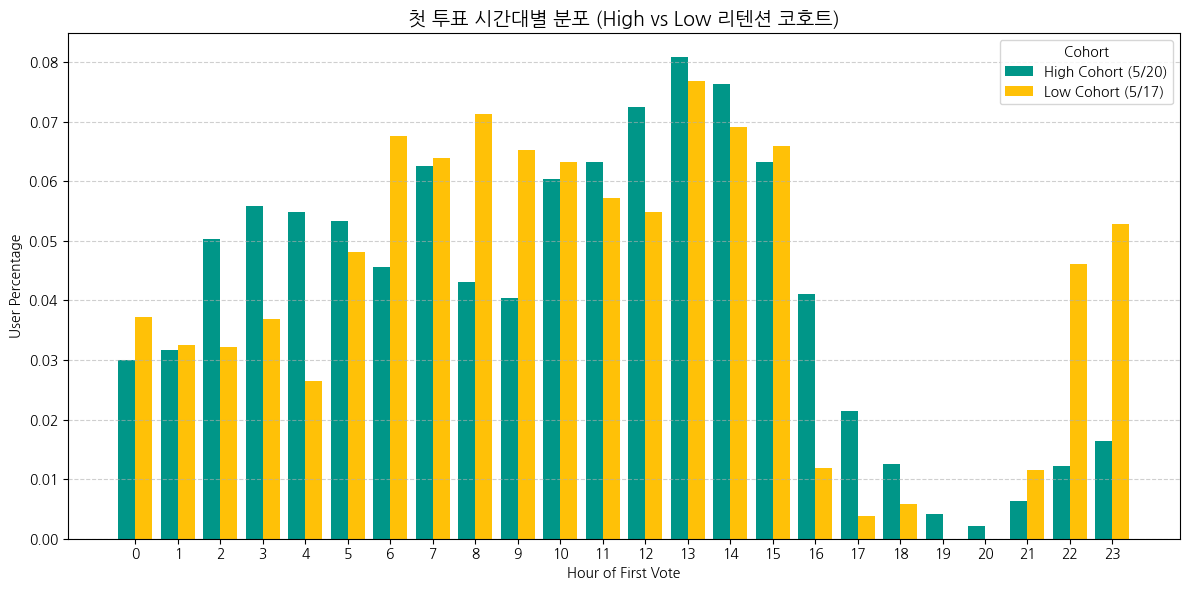

In [46]:

# 두 코호트에서 first_vote_hour 비율 계산
high_hour = high_cohort['first_vote_hour'].value_counts(normalize=True).sort_index()
low_hour = low_cohort['first_vote_hour'].value_counts(normalize=True).sort_index()

# 하나의 데이터프레임으로 병합
hour_df = pd.concat([high_hour, low_hour], axis=1, keys=['High Cohort', 'Low Cohort']).fillna(0)

# 시각화
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.4
index = range(len(hour_df))

# 바 플롯 (커스텀 색상)
ax.bar(
    [i - bar_width/2 for i in index],
    hour_df['High Cohort'],
    width=bar_width,
    label='High Cohort (5/20)',
    color='#009688'
)

ax.bar(
    [i + bar_width/2 for i in index],
    hour_df['Low Cohort'],
    width=bar_width,
    label='Low Cohort (5/17)',
    color='#ffc107'
)

# 라벨, 스타일
ax.set_title('첫 투표 시간대별 분포 (High vs Low 리텐션 코호트)', fontsize=14)
ax.set_xlabel('Hour of First Vote')
ax.set_ylabel('User Percentage')
ax.set_xticks(index)
ax.set_xticklabels(hour_df.index)
ax.legend(title='Cohort')
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [47]:
import datetime

# 날짜 필드가 datetime이면 → date로 자르기
day0_df['first_vote_date'] = pd.to_datetime(day0_df['first_vote_date']).dt.date

# 비교용 날짜도 date 타입으로 지정
high_date = datetime.date(2023, 5, 20)
low_date  = datetime.date(2023, 5, 17)

# 코호트 필터
high_cohort = day0_df[day0_df['first_vote_date'] == high_date]
low_cohort  = day0_df[day0_df['first_vote_date'] == low_date]

# 유니크 유저 수 출력
high_count = high_cohort['user_id'].nunique()
low_count = low_cohort['user_id'].nunique()

high_count, low_count

(163, 69)

In [48]:
import datetime

# 날짜 컬럼을 date로 자르기
day0_df['first_vote_date'] = pd.to_datetime(day0_df['first_vote_date']).dt.date

# 실제 존재하는 날짜 확인
day0_df['first_vote_date'].value_counts().sort_index()


first_vote_date
2023-04-29     6947
2023-04-30     5855
2023-05-01     1497
2023-05-02     3670
2023-05-03    18378
2023-05-04     7944
2023-05-05    27406
2023-05-06     8501
2023-05-07     3757
2023-05-08     5507
2023-05-09     8959
2023-05-10     6643
2023-05-11    19067
2023-05-12    18000
2023-05-13    26350
2023-05-14     8515
2023-05-15    10374
2023-05-16     6165
2023-05-17     3448
2023-05-18     6267
2023-05-19     2772
2023-05-20    13186
2023-05-21    10000
2023-05-22     5556
2023-05-23     4006
2023-05-24     2586
Name: count, dtype: int64

### 5월 17일과 5월 20일 코호트 유저들의 행동 데이터를 요약한 세 가지 핵심 지표

In [49]:
# 날짜를 date 타입으로 변환
day0_df['first_vote_date'] = pd.to_datetime(day0_df['first_vote_date']).dt.date

# 비교 대상 날짜
target_dates = [datetime.date(2023, 5, 20), datetime.date(2023, 5, 17)]

# 해당 날짜에 첫 투표한 유저만 필터링
filtered_df = day0_df[day0_df['first_vote_date'].isin(target_dates)].copy()

In [50]:
# ── 1. 유저-일(day) 단위 행동 횟수 집계 ─────────────────
action_counts = (
    retention_df.groupby(['user_id', 'days_since_first'])
    .size()
    .reset_index(name='action_count')
)

# ── 2. 유저별 행동 요약(총 활동일 수·첫날·마지막날) ────────
user_behavior_summary = (
    action_counts.groupby('user_id')['days_since_first']
    .agg(
        total_active_days='count',   # 총 며칠간 활동했나
        first_day='min',             # 최초 활동일(0)
        last_day='max'               # 마지막 활동일
    )
    .reset_index()
)

# ── 3. 파생 변수 추가 ─────────────────────────────────────
user_behavior_summary['active_span'] = (
    user_behavior_summary['last_day'] - user_behavior_summary['first_day']
)                      # 첫날~마지막날 간격
user_behavior_summary['avg_gap'] = (
    user_behavior_summary['active_span'] / user_behavior_summary['total_active_days']
).round(2)             # 평균 행동 간격(일) – 소수 둘째 자리까지만

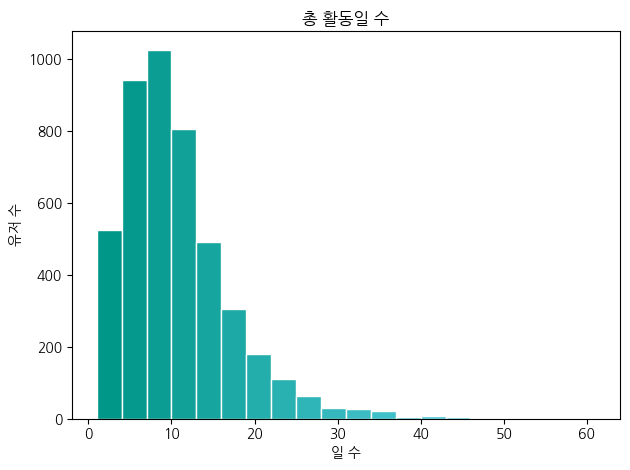

/tmp/ipykernel_3642790/3323632316.py:40: UserWarning: Glyph 8202 (\N{HAIR SPACE}) missing from font(s) NanumGothic.
  plt.tight_layout()
/home/eunyu/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8202 (\N{HAIR SPACE}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


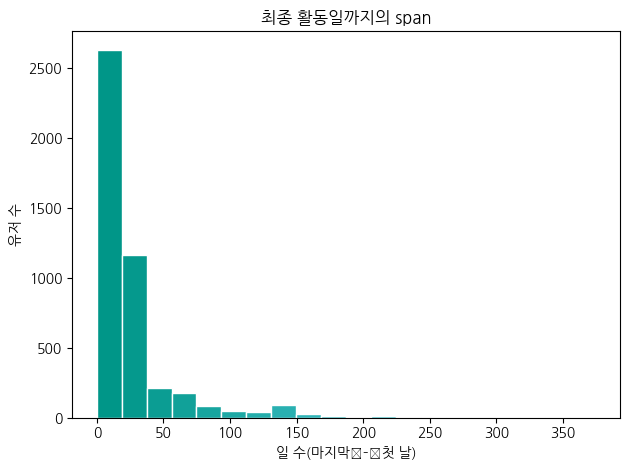

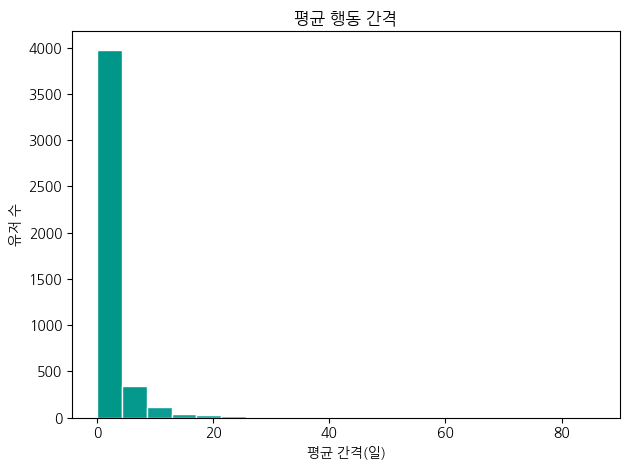

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# --------- 유틸: 두 HEX 색 사이 그래디언트 ---------
def gradient_colors(n, start="#009688", end="#70dff8"):
    s = np.array([int(start[i:i+2], 16) for i in (1, 3, 5)])
    e = np.array([int(end[i:i+2], 16) for i in (1, 3, 5)])
    return [
        "#" + "".join(f"{v:02x}" for v in (s + (e - s) * t).astype(int))
        for t in np.linspace(0, 1, n)
    ]

# 그래디언트 팔레트(막대 개수=bins 수와 같게 맞춰야 함)
bins = 20
palette = gradient_colors(bins)

# --------- 1) 총 활동일 수 ---------
plt.figure()
counts, edges, patches = plt.hist(
    user_behavior_summary["total_active_days"], bins=bins, edgecolor="white"
)
for c, p in zip(palette, patches):
    p.set_facecolor(c)
plt.title("총 활동일 수")
plt.xlabel("일 수")
plt.ylabel("유저 수")
plt.tight_layout()
plt.show()

# --------- 2) 활동 span ---------
plt.figure()
counts, edges, patches = plt.hist(
    user_behavior_summary["active_span"], bins=bins, edgecolor="white"
)
for c, p in zip(palette, patches):
    p.set_facecolor(c)
plt.title("최종 활동일까지의 span")
plt.xlabel("일 수(마지막 – 첫 날)")
plt.ylabel("유저 수")
plt.tight_layout()
plt.show()

# --------- 3) 평균 행동 간격 ---------
plt.figure()
counts, edges, patches = plt.hist(
    user_behavior_summary["avg_gap"], bins=bins, edgecolor="white"
)
for c, p in zip(palette, patches):
    p.set_facecolor(c)
plt.title("평균 행동 간격")
plt.xlabel("평균 간격(일)")
plt.ylabel("유저 수")
plt.tight_layout()
plt.show()


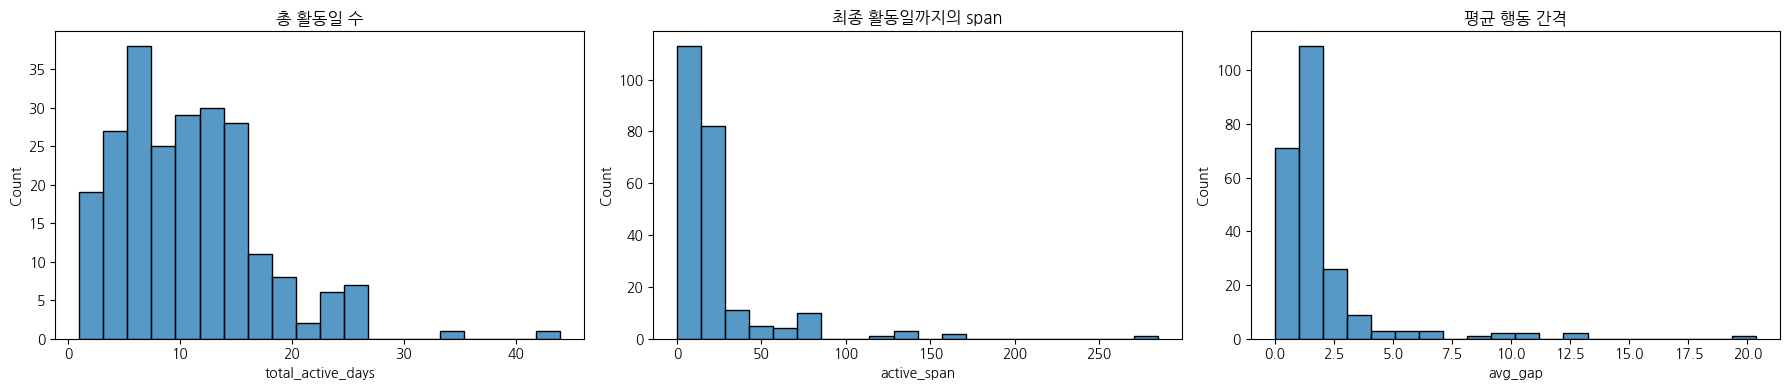

,user_id,total_active_days,first_day,last_day,active_span,avg_gap
count,2.320000e+02,232.000000,232.0,232.000000,232.000000,232.000000
mean,1.332222e+06,10.780172,0.0,22.793103,22.793103,1.951699
std,1.170384e+05,6.372896,0.0,31.245992,31.245992,2.282182
min,8.552300e+05,1.000000,0.0,0.000000,0.000000,0.000000
25%,1.318950e+06,6.000000,0.0,8.000000,8.000000,1.000000
50%,1.359282e+06,10.000000,0.0,15.000000,15.000000,1.266667
75%,1.404646e+06,14.000000,0.0,22.250000,22.250000,1.904167
max,1.414233e+06,44.000000,0.0,285.000000,285.000000,20.357143


In [52]:
# 두 날짜의 유저 리스트
target_users = filtered_df['user_id'].unique()

# 이 유저들의 전체 행동 로그 (retention_df에서 추출)
user_actions = retention_df[retention_df['user_id'].isin(target_users)].copy()

# Day 기준으로 행동 횟수 계산
action_counts = (
    user_actions.groupby(['user_id', 'days_since_first'])
    .size()
    .reset_index(name='action_count')
)

# 유저별 총 행동일 수, 평균 행동 간격, 최대 행동일 차이 등 파생
user_behavior_summary = (
    action_counts.groupby('user_id')['days_since_first']
    .agg(
        total_active_days='count',
        first_day='min',
        last_day='max'
    )
    .reset_index()
)

user_behavior_summary['active_span'] = user_behavior_summary['last_day'] - user_behavior_summary['first_day']
user_behavior_summary['avg_gap'] = user_behavior_summary['active_span'] / user_behavior_summary['total_active_days']

import seaborn as sns
import matplotlib.pyplot as plt

# 히스토그램 시각화
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
sns.histplot(user_behavior_summary['total_active_days'], bins=20, ax=axs[0])
axs[0].set_title('총 활동일 수')

sns.histplot(user_behavior_summary['active_span'], bins=20, ax=axs[1])
axs[1].set_title('최종 활동일까지의 span')

sns.histplot(user_behavior_summary['avg_gap'], bins=20, ax=axs[2])
axs[2].set_title('평균 행동 간격')

plt.tight_layout()
plt.show()

# 통계 요약
user_behavior_summary.describe()

1. total_active_days(유저가 투표한 총 일 수): 대부분 5~15일 사이, 일부는 30일 이상 유지
2. active_span(첫 투표일부터 마지막 투표일까지의 전체 기간): 일부 유저는 수십~200일 이상 동안 분산된 활동
3. avg_gap(평균 행동 간격 (일) = active_span / total_active_days): 75% 유저는 2일 이내 간격으로 행동 (즉, 자주 옴)

### 전체 투표 인원 기준으로, 각 유저가 몇 건의 투표를 했는가

In [53]:
vote_count_per_user = userquestionrecord_df['user_id'].value_counts().reset_index()
vote_count_per_user.columns = ['user_id', 'vote_count']


In [54]:
vote_count_per_user

,user_id,vote_count
0,849103,2786
1,876509,1708
2,856042,1701
3,1213990,1695
4,1159163,1656
...,...,...
4844,985719,1
4845,885441,1
4846,875207,1
4847,951655,1


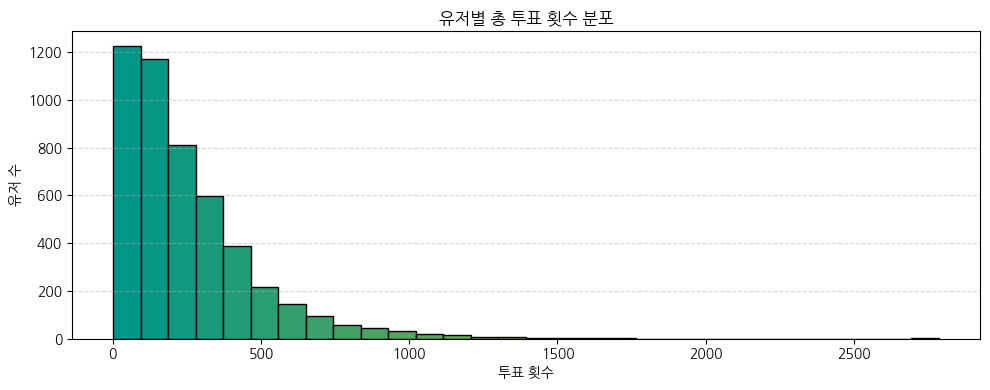

In [55]:
# 연한 색상 팔레트 생성 (두 가지 색상을 그라데이션으로 혼합)
from matplotlib.colors import LinearSegmentedColormap

# 커스텀 그라데이션 컬러맵 정의
colors = ['#009688', '#ffc107']
cmap = LinearSegmentedColormap.from_list("custom", colors)

# 히스토그램 시각화
plt.figure(figsize=(10, 4))
n, bins, patches = plt.hist(vote_count_per_user['vote_count'], bins=30, edgecolor='black')

# 색상 그라데이션 적용
for patch, bin_left in zip(patches, bins):
    patch.set_facecolor(cmap((bin_left - min(bins)) / (max(bins) - min(bins))))

plt.title('유저별 총 투표 횟수 분포')
plt.xlabel('투표 횟수')
plt.ylabel('유저 수')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [56]:
# 유저별 투표 수 집계
vote_count_per_user = userquestionrecord_df['user_id'].value_counts().reset_index()
vote_count_per_user.columns = ['user_id', 'vote_count']

# 1000회 이상 투표한 유저 수
heavy_user_count = (vote_count_per_user['vote_count'] >= 1000).sum()
heavy_user_count


70

### 행동지표 비교

In [57]:

# 날짜 처리
retention_df['first_vote_date'] = pd.to_datetime(retention_df['first_vote_date']).dt.date
high_date = datetime.date(2023, 5, 20)
low_date  = datetime.date(2023, 5, 17)

# day0 기준 데이터에서 코호트 추출
day0_df = retention_df[retention_df['days_since_first'] == 0].copy()
high_cohort = day0_df[day0_df['first_vote_date'] == high_date]
low_cohort  = day0_df[day0_df['first_vote_date'] == low_date]


In [58]:
# 평균 열람률
avg_read_high = (high_cohort['has_read'] == 1).mean()
avg_read_low = (low_cohort['has_read'] == 1).mean()

# 평균 응답률
avg_answer_high = (high_cohort['answer_status'] != 'N').mean()
avg_answer_low = (low_cohort['answer_status'] != 'N').mean()

# 열람 대비 응답 비율
read_answer_ratio_high = avg_answer_high / avg_read_high
read_answer_ratio_low = avg_answer_low / avg_read_low

# 결과 정리
behavior_comparison = {
    'avg_read_rate': {'high': avg_read_high, 'low': avg_read_low},
    'avg_answer_rate': {'high': avg_answer_high, 'low': avg_answer_low},
    'read_to_answer_ratio': {'high': read_answer_ratio_high, 'low': read_answer_ratio_low}
}

behavior_comparison


{'avg_read_rate': {'high': 0.822235704535113, 'low': 0.6728538283062645},
 'avg_answer_rate': {'high': 0.09980282117397239, 'low': 0.17923433874709976},
 'read_to_answer_ratio': {'high': 0.12137981922154584,
  'low': 0.2663793103448276}}

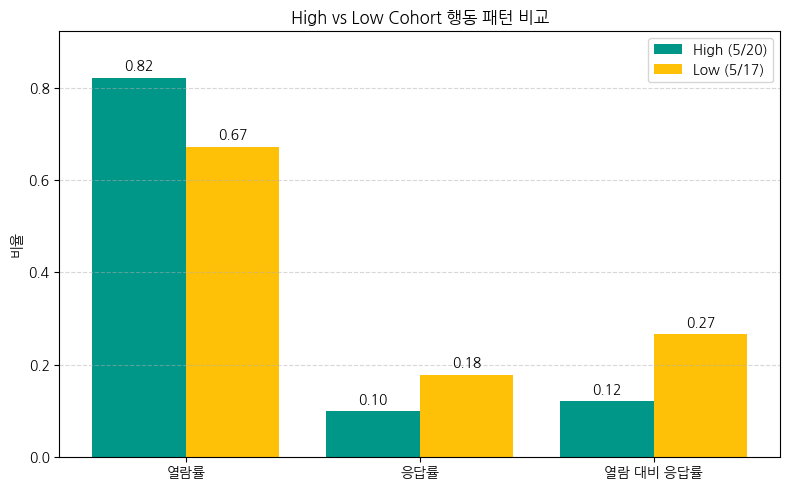

In [59]:

# 비교할 지표들
metrics = ['avg_read_rate', 'avg_answer_rate', 'read_to_answer_ratio']
high_values = [0.822, 0.0998, 0.121]
low_values = [0.672, 0.179, 0.266]

x = range(len(metrics))

plt.figure(figsize=(8, 5))
bar1 = plt.bar(x, high_values, width=0.4, label='High (5/20)', color='#009688')
bar2 = plt.bar([i + 0.4 for i in x], low_values, width=0.4, label='Low (5/17)', color='#ffc107')

# 값 표시
for bars in [bar1, bar2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.xticks([i + 0.2 for i in x], ['열람률', '응답률', '열람 대비 응답률'])
plt.ylim(0, max(max(high_values), max(low_values)) + 0.1)
plt.title('High vs Low Cohort 행동 패턴 비교')
plt.ylabel('비율')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### 활동일 수 비교

In [60]:
# high_cohort와 low_cohort 다시 정의


# 날짜 필드가 datetime이면 → date로 자르기
day0_df['first_vote_date'] = pd.to_datetime(day0_df['first_vote_date']).dt.date

# 비교용 날짜도 date 타입으로 지정
high_date = datetime.date(2023, 5, 20)
low_date  = datetime.date(2023, 5, 17)

# 코호트 필터
high_cohort = day0_df[day0_df['first_vote_date'] == high_date]
low_cohort  = day0_df[day0_df['first_vote_date'] == low_date]

# 원본 데이터프레임에서 해당 유저들의 전체 활동일 수 계산
high_users = high_cohort['user_id'].unique()
low_users = low_cohort['user_id'].unique()

# 원본 데이터프레임 사용 (retention_df)
high_activities = retention_df[retention_df['user_id'].isin(high_users)]
low_activities = retention_df[retention_df['user_id'].isin(low_users)]

# 유저별 활동일 수
high_active_days = high_activities.groupby('user_id')['created_at'].apply(lambda x: x.dt.date.nunique())
low_active_days = low_activities.groupby('user_id')['created_at'].apply(lambda x: x.dt.date.nunique())

# 평균 활동일 수 계산
avg_high_active_days = high_active_days.mean()
avg_low_active_days = low_active_days.mean()

avg_high_active_days, avg_low_active_days


(12.257668711656441, 9.173913043478262)

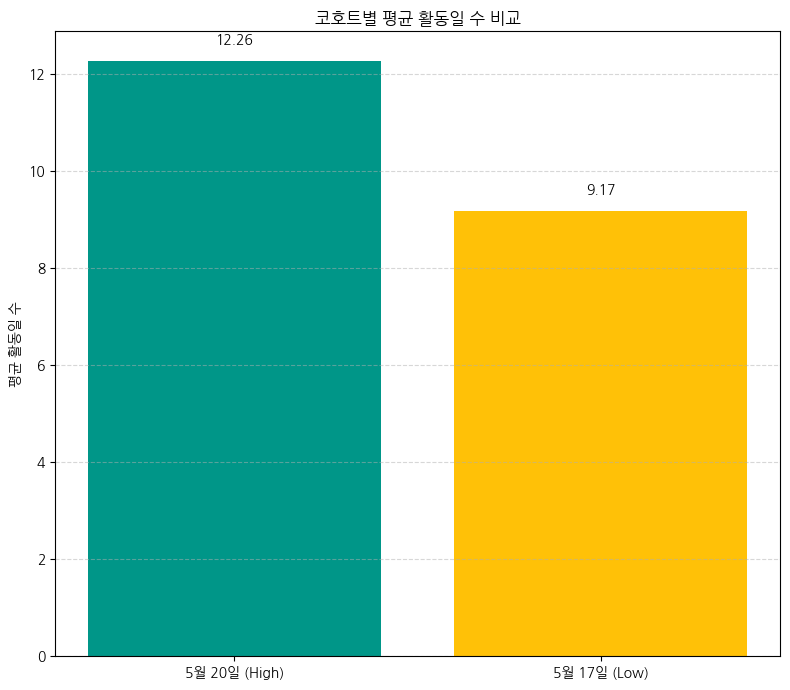

In [61]:

# 데이터
labels = ['5월 20일 (High)', '5월 17일 (Low)']
values = [12.26, 9.17]
colors = ['#009688', '#ffc107']

# 시각화
plt.figure(figsize=(8, 7))
bars = plt.bar(labels, values, color=colors, edgecolor='none')

# 비율 텍스트 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.3, f'{height:.2f}', 
             ha='center', va='bottom', fontsize=10)

plt.title('코호트별 평균 활동일 수 비교')
plt.ylabel('평균 활동일 수')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### 첫날 열람 건 수 

### 첫날 투표 건 수

In [62]:
# 유저별 최초 투표일 계산
user_first_vote = (
    retention_df.groupby('user_id')['vote_date']
    .min()
    .reset_index()
    .rename(columns={'vote_date': 'first_vote_date'})
)

# retention_df에 병합
retention_df = retention_df.merge(user_first_vote, on='user_id', how='left')


In [63]:
# 1. 기준 날짜
high_cohort_date = pd.to_datetime('2023-05-20')
low_cohort_date = pd.to_datetime('2023-05-17')

# 2. first_vote_date 계산
user_first_vote = (
    retention_df.groupby('user_id')['created_at']
    .min()
    .reset_index()
    .rename(columns={'created_at': 'first_vote_date'})
)
retention_df = retention_df.merge(user_first_vote, on='user_id', how='left')

# 3. 코호트 유저
high_cohort_users = retention_df[retention_df['first_vote_date'].dt.date == high_cohort_date.date()]['user_id'].unique()
low_cohort_users = retention_df[retention_df['first_vote_date'].dt.date == low_cohort_date.date()]['user_id'].unique()

# 4. 유저별 실제 '첫날' 기록
first_day_vote_logs = retention_df[
    retention_df['created_at'].dt.date == retention_df['first_vote_date'].dt.date
]

# 5. 각 집단 필터
high_votes = first_day_vote_logs[first_day_vote_logs['user_id'].isin(high_cohort_users)]
low_votes = first_day_vote_logs[first_day_vote_logs['user_id'].isin(low_cohort_users)]

# 6. 출력
print(f"high 코호트 첫날 투표 건수: {len(high_votes)}")
print(f"low 코호트 첫날 투표 건수: {len(low_votes)}")

high_views = high_votes[high_votes['has_read'] == 1]
low_views = low_votes[low_votes['has_read'] == 1]

print(f"high 코호트 첫날 열람 건수: {len(high_views)}")
print(f"low 코호트 첫날 열람 건수: {len(low_views)}")


high 코호트 첫날 투표 건수: 4676
low 코호트 첫날 투표 건수: 2247
high 코호트 첫날 열람 건수: 4019
low 코호트 첫날 열람 건수: 1487


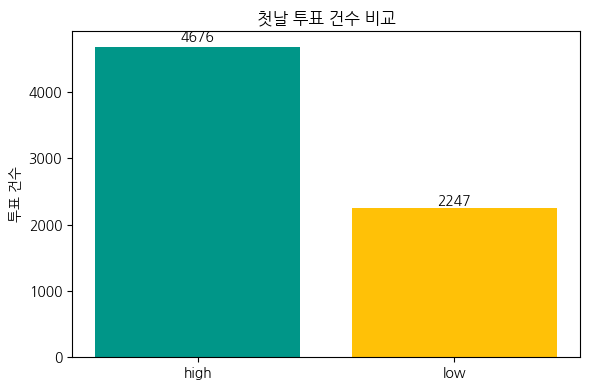

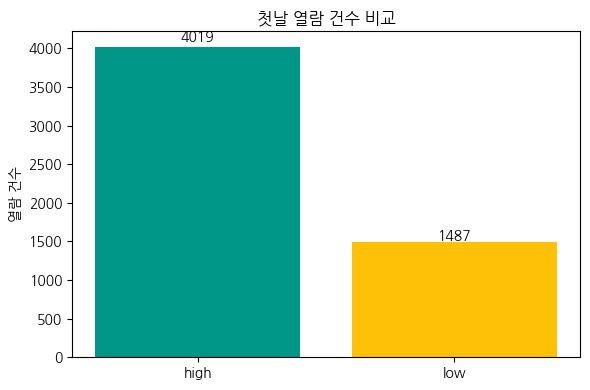

In [64]:

# --- PARAMETERS -----------------------------------
high_cohort_date = pd.to_datetime('2023-05-20')
low_cohort_date  = pd.to_datetime('2023-05-17')

# --- 1) 최초 투표일 계산 ---------------------------
user_first_vote = (
    retention_df.groupby('user_id')['created_at']
    .min()
    .reset_index()
    .rename(columns={'created_at': 'first_vote_date'})
)

# 충돌 방지 후 병합
retention_df = retention_df.drop(columns=['first_vote_date'], errors='ignore')
retention_df = retention_df.merge(user_first_vote, on='user_id', how='left')

# --- 2) 코호트 유저 추출 ---------------------------
high_users = retention_df[
    retention_df['first_vote_date'].dt.date == high_cohort_date.date()
]['user_id'].unique()

low_users = retention_df[
    retention_df['first_vote_date'].dt.date == low_cohort_date.date()
]['user_id'].unique()

# --- 3) 유저별 ‘첫날’ 로그 -------------------------
first_day_logs = retention_df[
    retention_df['created_at'].dt.date == retention_df['first_vote_date'].dt.date
]

high_votes = first_day_logs[first_day_logs['user_id'].isin(high_users)]
low_votes  = first_day_logs[first_day_logs['user_id'].isin(low_users)]

high_views = high_votes[high_votes['has_read'] == 1]
low_views  = low_votes[low_votes['has_read'] == 1]

# --- 4) 시각화 ------------------------------------
labels   = ['high', 'low']
colors   = ['#009688', '#ffc107']

# (a) 첫날 투표 건수
plt.figure(figsize=(6,4))
plt.bar(labels, [len(high_votes), len(low_votes)], color=colors)
plt.title('첫날 투표 건수 비교')
plt.ylabel('투표 건수')
for i, v in enumerate([len(high_votes), len(low_votes)]):
    plt.text(i, v*1.02, v, ha='center')
plt.tight_layout()

# (b) 첫날 열람 건수
plt.figure(figsize=(6,4))
plt.bar(labels, [len(high_views), len(low_views)], color=colors)
plt.title('첫날 열람 건수 비교')
plt.ylabel('열람 건수')
for i, v in enumerate([len(high_views), len(low_views)]):
    plt.text(i, v*1.02, v, ha='center')
plt.tight_layout()

plt.show()


In [67]:
summary_df = pd.DataFrame({
    'cohort_group': ['high', 'low'],
    'first_day_votes': [len(high_votes), len(low_votes)],
    'first_day_views': [len(high_views), len(low_views)]
})

summary_df

,cohort_group,first_day_votes,first_day_views
0,high,4676,4019
1,low,2247,1487


In [73]:
import os

save_dir = os.path.expanduser("~/data")  # 예: /home/eunyu/data
os.makedirs(save_dir, exist_ok=True)

file_path = os.path.join(save_dir, "first_day_vote_view_counts.csv")
summary_df.to_csv(file_path, index=False)

print(f"저장 완료: {file_path}")


저장 완료: /home/eunyu/data/first_day_vote_view_counts.csv


### 소속학교, 학년, 성별

In [ ]:
import pandas as pd

# ──────────────────────────────────────────────
# 0) 8일차 리텐션 기준으로 high / low 코호트 날짜 구하기

# ──────────────────────────────────────────────
# ① 유저-일 단위 중복 제거
ret_unique = retention_df.drop_duplicates(subset=['user_id', 'days_since_first'])

# ② 코호트×day별 잔존 유저 수
cohort_day = (
    ret_unique.groupby(['first_vote_date', 'days_since_first'])['user_id']
    .nunique()
    .reset_index(name='users')
)

# ③ 피벗 → 비율화
mat = cohort_day.pivot(index='first_vote_date', columns='days_since_first', values='users').fillna(0)
rate = mat.div(mat[0], axis=0)              # Day 0 대비 비율

# ④ 8일차(컬럼 8) 기준 high / low 코호트 날짜 추출
high_dates = rate[rate[8] >= 0.50].index     # DatetimeIndex
low_dates  = rate[rate[8] <  0.50].index

# ──────────────────────────────────────────────
# 1) high / low 유저 ID 집합 만들기
# ──────────────────────────────────────────────
high_users = retention_df[retention_df['first_vote_date'].isin(high_dates)]['user_id'].unique()
low_users  = retention_df[retention_df['first_vote_date'].isin(low_dates) ]['user_id'].unique()

# ──────────────────────────────────────────────
# 2) 유저 메타 정보 병합 (성별·학년·학교)
# ──────────────────────────────────────────────
user_info = (
    user_df.rename(columns={'id':'user_id'})
    .merge(group_df.rename(columns={'id':'group_id'})[['group_id','school_id','grade']],
           on='group_id', how='left')
)

high_info = user_info[user_info['user_id'].isin(high_users)]
low_info  = user_info[user_info['user_id'].isin(low_users)]

# ──────────────────────────────────────────────
# 3) 분포 출력
# ──────────────────────────────────────────────
print("[High] 성별 분포")
print(high_info['gender'].value_counts(), '\n')

print("[Low] 성별 분포")
print(low_info['gender'].value_counts(), '\n')

print("[High] 학년 분포")
print(high_info['grade'].value_counts(), '\n')

print("[Low] 학년 분포")
print(low_info['grade'].value_counts(), '\n')

print("[High] 학교 ID 분포")
print(high_info['school_id'].value_counts(), '\n')

print("[Low] 학교 ID 분포")
print(low_info['school_id'].value_counts(), '\n')


[High] 성별 분포
gender
F    1100
M     802
Name: count, dtype: int64 

[Low] 성별 분포
gender
F    1356
M    1289
Name: count, dtype: int64 

[High] 학년 분포
grade
1.0    749
2.0    706
3.0    447
Name: count, dtype: int64 

[Low] 학년 분포
grade
2.0    1138
1.0     920
3.0     587
Name: count, dtype: int64 

[High] 학교 ID 분포
school_id
5520.0    275
4426.0    215
1478.0    203
5491.0    195
1719.0    193
5372.0    187
4516.0    180
369.0     178
271.0     145
352.0     131
Name: count, dtype: int64 

[Low] 학교 ID 분포
school_id
369.0     357
1719.0    345
352.0     328
5372.0    287
4516.0    261
5491.0    260
1478.0    239
4426.0    202
271.0     190
5520.0    176
Name: count, dtype: int64 



### 이성에게 받은 투표수

In [88]:
import pandas as pd

# ──────────────────────────────────────────────
# 0) 코호트별 8 일차 리텐션 ≥ 50% 여부 계산
# ──────────────────────────────────────────────
# ① 유저-일 중복 제거
ret_unique = retention_df.drop_duplicates(
    subset=['user_id', 'days_since_first']
)

# ② 코호트×day별 유저 수 집계
cohort_day = (
    ret_unique
    .groupby(['first_vote_date', 'days_since_first'])['user_id']
    .nunique()
    .reset_index(name='users')
)

# ③ 피벗 후 8 일차 비율 계산
mat  = cohort_day.pivot(index='first_vote_date',
                        columns='days_since_first',
                        values='users').fillna(0)
rate = mat.div(mat[0], axis=0)

# ④ 8 일차 기준 high / low 날짜 목록
high_dates = rate[rate[8] >= 0.50].index      # DatetimeIndex
low_dates  = rate[rate[8] <  0.50].index

# ──────────────────────────────────────────────
# 1) 코호트 유저 집합(high / low)
# ──────────────────────────────────────────────
high_users = retention_df[
    retention_df['first_vote_date'].isin(high_dates)
]['user_id'].unique()

low_users = retention_df[
    retention_df['first_vote_date'].isin(low_dates)
]['user_id'].unique()

# ──────────────────────────────────────────────
# 2) 투표 데이터 준비 + 성별 정보 병합
# ──────────────────────────────────────────────
user_gender = user_df[['id', 'gender']].rename(columns={'id': 'user_id'})

votes_received = retention_df[['user_id', 'chosen_user_id']].copy()

votes_received = (
    votes_received
    .merge(user_gender, on='user_id', how='left')                 # 발신자 성별
    .rename(columns={'gender': 'sender_gender'})
    .merge(user_gender.rename(columns={'user_id':'chosen_user_id',
                                       'gender':'receiver_gender'}),
           on='chosen_user_id', how='left')                       # 수신자 성별
)

# ──────────────────────────────────────────────
# 3) 전체 투표 vs 이성 투표
# ──────────────────────────────────────────────
#   – 이성 투표만 필터: sender_gender ≠ receiver_gender
votes_opposite_gender = votes_received[
    votes_received['sender_gender'] != votes_received['receiver_gender']
]

#   – 각 코호트 유저가 ‘받은’ 투표(=chosen_user_id) 만 집계
high_total = votes_received[
    votes_received['chosen_user_id'].isin(high_users)
]
low_total  = votes_received[
    votes_received['chosen_user_id'].isin(low_users)
]

high_opp = votes_opposite_gender[
    votes_opposite_gender['chosen_user_id'].isin(high_users)
]
low_opp  = votes_opposite_gender[
    votes_opposite_gender['chosen_user_id'].isin(low_users)
]

# ──────────────────────────────────────────────
# 4) 결과 출력
# ──────────────────────────────────────────────
def show(group, total_df, opp_df):
    total = len(total_df)
    opp   = len(opp_df)
    ratio = opp / total if total else 0
    print(f"[{group}] 전체 받은 투표 수 : {total:,}")
    print(f"[{group}] 받은 이성 투표 수 : {opp:,}")
    print(f"[{group}] 이성 투표 비율    : {ratio:.2%}\n")

show("High", high_total, high_opp)
show("Low",  low_total,  low_opp)


[High] 전체 받은 투표 수 : 467,123
[High] 받은 이성 투표 수 : 137,545
[High] 이성 투표 비율    : 29.45%

[Low] 전체 받은 투표 수 : 509,956
[Low] 받은 이성 투표 수 : 139,976
[Low] 이성 투표 비율    : 27.45%



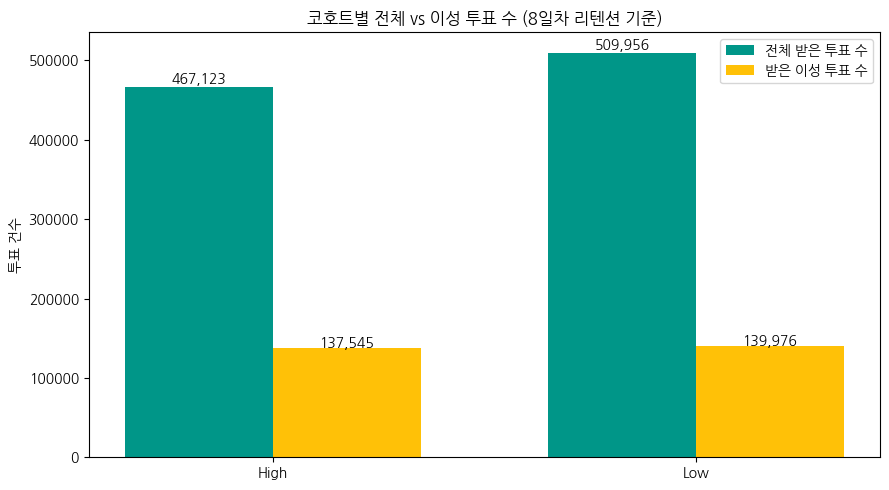

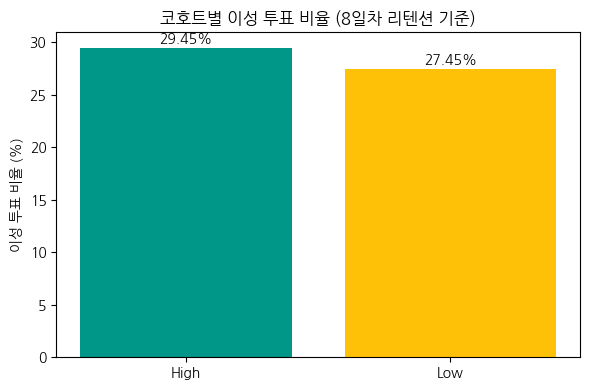

In [91]:
import matplotlib.pyplot as plt

# 최신 계산된 값 사용
labels = ['High', 'Low']
total_votes = [len(high_total), len(low_total)]
opposite_votes = [len(high_opp), len(low_opp)]
ratios = [v / t if t else 0 for v, t in zip(opposite_votes, total_votes)]

# (1) 전체 vs 이성 투표 수
x = range(len(labels))
width = 0.35
plt.figure(figsize=(9, 5))
plt.bar(x, total_votes, width=width, label='전체 받은 투표 수', color='#009688')
plt.bar([p + width for p in x], opposite_votes, width=width, label='받은 이성 투표 수', color='#FFC107')

# 라벨
for i in x:
    plt.text(i, total_votes[i] * 1.01, f"{total_votes[i]:,}", ha='center')
    plt.text(i + width, opposite_votes[i] * 1.01, f"{opposite_votes[i]:,}", ha='center')

plt.xticks([p + width / 2 for p in x], labels)
plt.ylabel('투표 건수')
plt.title('코호트별 전체 vs 이성 투표 수 (8일차 리텐션 기준)')
plt.legend()
plt.tight_layout()
plt.show()

# (2) 이성 투표 비율
plt.figure(figsize=(6, 4))
plt.bar(labels, [r * 100 for r in ratios], color=['#009688', '#FFC107'])
for i, r in enumerate(ratios):
    plt.text(i, r * 100 + 0.5, f"{r:.2%}", ha='center')
plt.ylabel('이성 투표 비율 (%)')
plt.title('코호트별 이성 투표 비율 (8일차 리텐션 기준)')
plt.tight_layout()
plt.show()
